#Breast Cancer Wisconsin Dataset

In [32]:
#Install dependencies
!pip install fastai
!pip install nbdev
!pip install ucimlrepo

#Import libraries
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import fastai
from fastai.tabular.all import *
import torch
import torch.nn.functional as F
import torch.nn as nn
import pickle
import copy
import time
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

#Connect to drive
#from google.colab import drive
#drive.mount('/content/drive')

#Convert and import personalised library
#!jupyter nbconvert --to python /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.ipynb --output utilsTFG.py
#!cp /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.py .
import utilstfg as utilsTFG


In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Set seed for fastai
fastai.torch_core.set_seed(42)

# Set seed for torch
torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(42)

# Set seed for numpy
np.random.seed(42)

cuda


### Datos y modelos

In [34]:
dataset='bcw'
plot_dataset='BCW'
#Load the dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)

X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

#Show the data
print(X.head())


# Show metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

# Show variable information
print(breast_cancer_wisconsin_diagnostic.variables)

df=pd.concat([X, y], axis=1)



# Define the categorical and continuous variables
cat_names = []
cont_names = list(X.columns)
dep_var = 'Diagnosis'


   radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0    17.99     10.38      122.80  1001.0      0.11840       0.27760   
1    20.57     17.77      132.90  1326.0      0.08474       0.07864   
2    19.69     21.25      130.00  1203.0      0.10960       0.15990   
3    11.42     20.38       77.58   386.1      0.14250       0.28390   
4    20.29     14.34      135.10  1297.0      0.10030       0.13280   

   concavity1  concave_points1  symmetry1  fractal_dimension1  ...  radius3  \
0      0.3001          0.14710     0.2419             0.07871  ...    25.38   
1      0.0869          0.07017     0.1812             0.05667  ...    24.99   
2      0.1974          0.12790     0.2069             0.05999  ...    23.57   
3      0.2414          0.10520     0.2597             0.09744  ...    14.91   
4      0.1980          0.10430     0.1809             0.05883  ...    22.54   

   texture3  perimeter3   area3  smoothness3  compactness3  concavity3  \
0     17.33      184.60 

In [35]:
#Handle missing data
missing_values = df.isna().sum()
print(missing_values)

radius1               0
texture1              0
perimeter1            0
area1                 0
smoothness1           0
compactness1          0
concavity1            0
concave_points1       0
symmetry1             0
fractal_dimension1    0
radius2               0
texture2              0
perimeter2            0
area2                 0
smoothness2           0
compactness2          0
concavity2            0
concave_points2       0
symmetry2             0
fractal_dimension2    0
radius3               0
texture3              0
perimeter3            0
area3                 0
smoothness3           0
compactness3          0
concavity3            0
concave_points3       0
symmetry3             0
fractal_dimension3    0
Diagnosis             0
dtype: int64


Diagnosis             1.000000
concave_points3       0.793566
perimeter3            0.782914
concave_points1       0.776614
radius3               0.776454
perimeter1            0.742636
area3                 0.733825
radius1               0.730029
area1                 0.708984
concavity1            0.696360
concavity3            0.659610
compactness1          0.596534
compactness3          0.590998
radius2               0.567134
perimeter2            0.556141
area2                 0.548236
texture3              0.456903
smoothness3           0.421465
symmetry3             0.416294
texture1              0.415185
concave_points2       0.408042
smoothness1           0.358560
symmetry1             0.330499
fractal_dimension3    0.323872
compactness2          0.292999
concavity2            0.253730
fractal_dimension2    0.077972
smoothness2           0.067016
fractal_dimension1    0.012838
texture2              0.008303
symmetry2             0.006522
dtype: float64


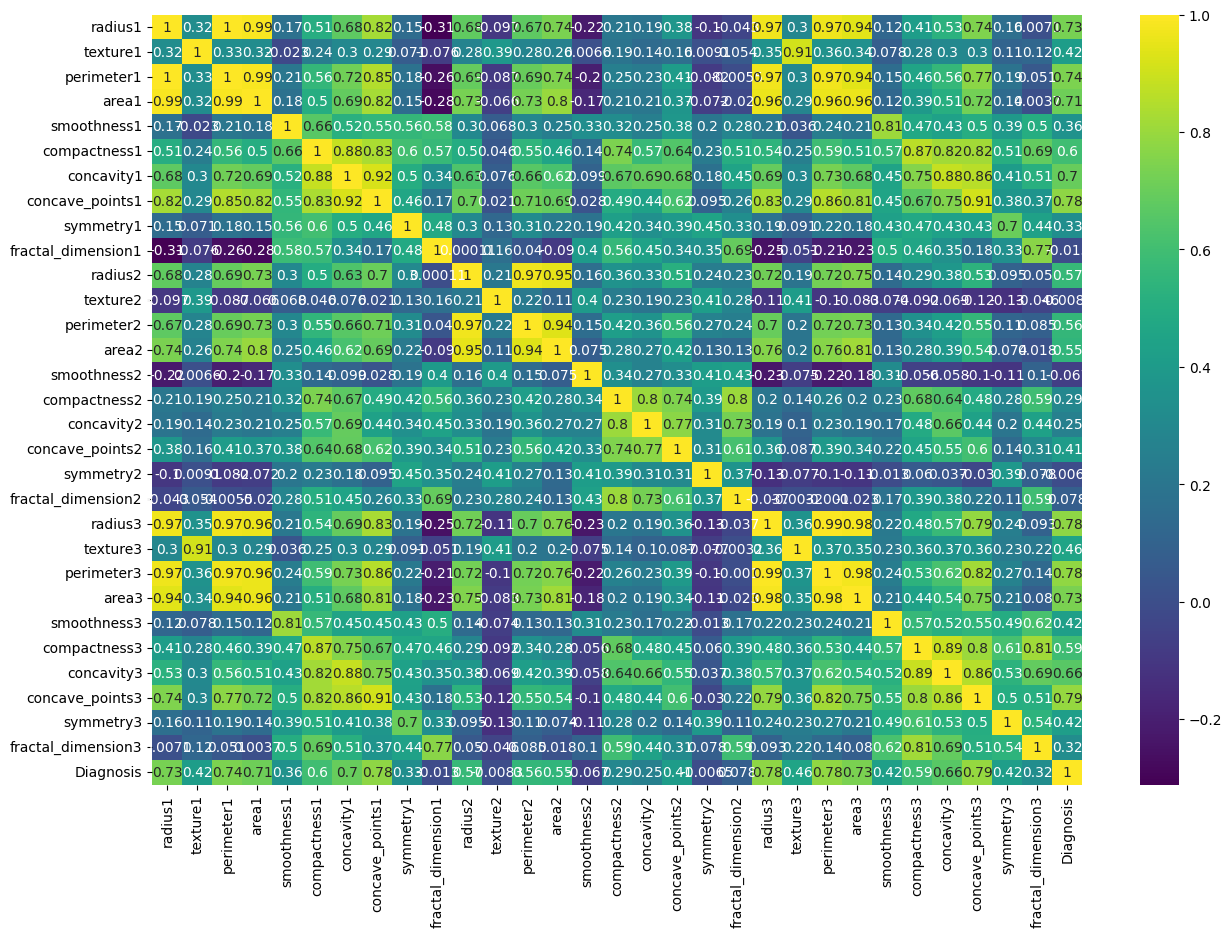

In [36]:
##Preprocessing


# Convert 'Diagnosis' column to numeric values
df['Diagnosis'] = df['Diagnosis'].map({'M': 1, 'B': 0})

#Correlation
corr_mat = df.corr()[dep_var]



#correlation with target
target_corr = np.abs(df.corrwith(df[dep_var]))
print(target_corr.sort_values(ascending=False))



#corrheat
corr_matrix = df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix,cmap="viridis", annot=True)
plt.show()
#Convert to Categorical again
df['Diagnosis'] = df['Diagnosis'].map({1: 'M', 0: 'B'})


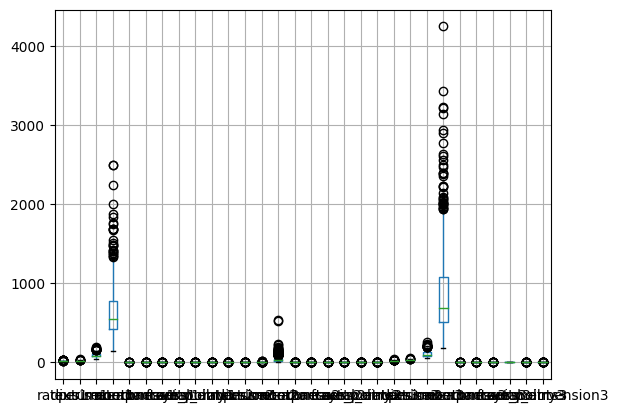

In [37]:
df.boxplot()
plt.show()

In [38]:
#Drop variables with low correlation with target
df.drop(['symmetry2', 'texture2', 'fractal_dimension1', 'smoothness2', 'fractal_dimension2'], axis=1, inplace=True)
cont_names.remove('symmetry2')
cont_names.remove('texture2')
cont_names.remove('fractal_dimension1')
cont_names.remove('smoothness2')
cont_names.remove('fractal_dimension2')

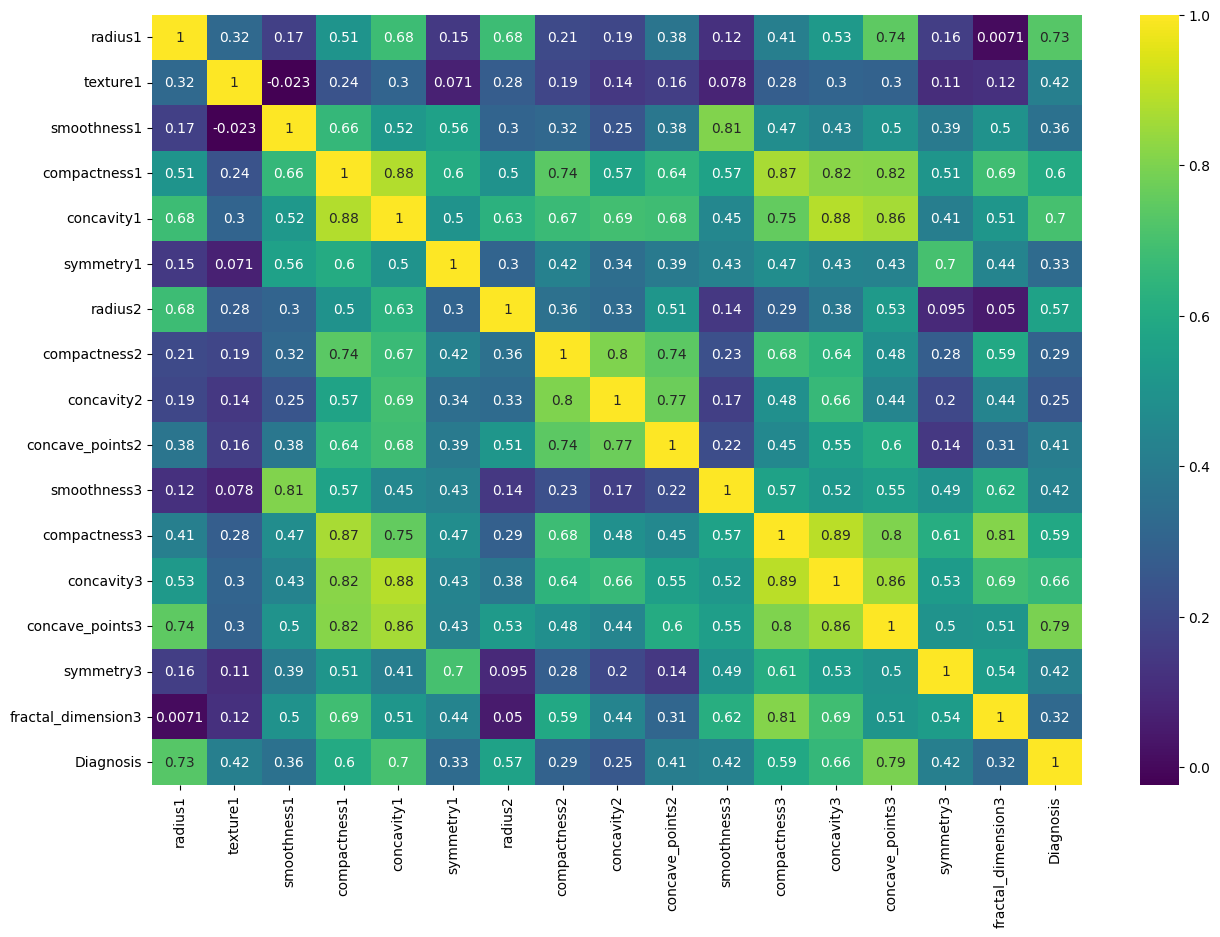

In [39]:
# Set the correlation threshold
df['Diagnosis'] = df['Diagnosis'].map({'M': 1, 'B': 0})
corr_matrix = df.corr()
threshold = 0.9


# Find pairs of features with correlation above the threshold
high_corr_pairs = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and corr_matrix.loc[i, j] > threshold]

to_drop = set()

for i, j in high_corr_pairs:
    if i not in to_drop and j not in to_drop:
        # Add one of the features to the drop list
        to_drop.add(j)

# Drop the identified features from the DataFrame
df.drop(columns=to_drop, inplace=True)
cont_names = [col for col in cont_names if col not in to_drop]
corr_matrix = df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix,cmap="viridis", annot=True)
plt.show()
df['Diagnosis'] = df['Diagnosis'].map({1: 'M', 0: 'B'})

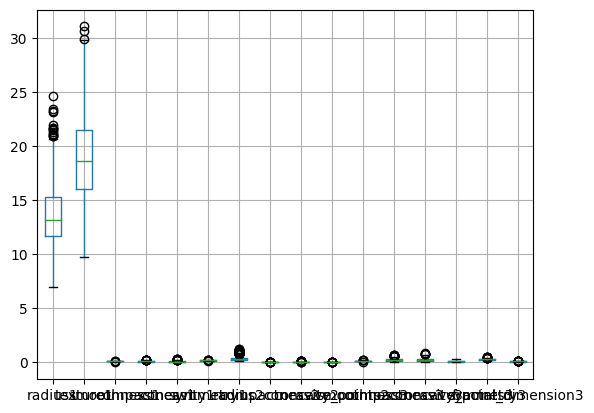

In [40]:
#Remove outliers
df_c = df.loc[(stats.zscore(df.drop([dep_var], axis=1)) < 3).all(axis=1)]
df_c.boxplot()
plt.show()

In [41]:
#Normalize
df_c = df_c.reset_index(drop=True)


# Split indices for training, validation, and test sets
train_val_split = RandomSplitter(valid_pct=0.3)(range_of(df_c))  # 70% for training/validation, 30% for testing
train_idx, val_test_idx = train_val_split

# Now split the validation/test set into validation and test sets (~20% test ~10% validation)
val_test_split = RandomSplitter(valid_pct=0.7)(val_test_idx)
val_idx, test_idx = val_test_split

# Combine all indices for the splits
splits = (train_idx, val_idx)

scaler = StandardScaler()
for feat in cont_names:
    df_c.loc[train_idx,feat] = scaler.fit_transform(df_c.loc[train_idx,[feat]])
    df_c.loc[val_idx,feat] = scaler.transform(df_c.loc[val_idx,[feat]])
    df_c.loc[test_idx,feat] = scaler.transform(df_c.loc[test_idx,[feat]])


In [42]:
df_c.columns

Index(['radius1', 'texture1', 'smoothness1', 'compactness1', 'concavity1',
       'symmetry1', 'radius2', 'compactness2', 'concavity2', 'concave_points2',
       'smoothness3', 'compactness3', 'concavity3', 'concave_points3',
       'symmetry3', 'fractal_dimension3', 'Diagnosis'],
      dtype='object')

In [43]:
df_c['radius1']

0      -3.693922
1      -3.784364
2      -3.722699
3      -0.406766
4       1.452628
         ...    
511    20.920000
512     2.513765
513    20.130000
514    16.600000
515    -1.910310
Name: radius1, Length: 516, dtype: float64

In [44]:
# Create TabularPandas for training and validation
to = TabularPandas(
    df_c,
    procs=[Categorify],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var,
    splits=splits
)


# Create DataLoaders for training and validation
dls = to.dataloaders(bs=32, shuffle=True)

test_to = TabularPandas(
    df_c.iloc[test_idx],  # Select only the test data
    procs=[Categorify],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var
)

# Create a DataLoader for the test set. Dont shuffle to get a more objective value across computations
test_dl = test_to.dataloaders(bs=32, shuffle=False)

dls.to(device)
test_dl.to(device)

In [45]:
#Initialise arrays for the loops
layers = [[64], [64, 64], [ 64, 128, 256, 128, 64], [32, 64, 128, 256, 512, 1024, 512, 256, 128, 64, 32] ]
n_layers=[1,2,5,11]
optims = ['NAG', 'RMSProp', 'ADAM']
names_layer=['1 layer', '2 layers', '5 layers', '11 layers']
algs = ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
metric = ['BalAcc']
init_weights = {}
for layer in n_layers:
  init_weights[layer] = {}

In [46]:
#For each number of layers initialise the model with the same parameters.
for layer in layers:
  learn = tabular_learner(dls, layers=layer, metrics=utilsTFG.balanced_accuracy_func, loss_func=CrossEntropyLossFlat())
  learn.model.apply(utilsTFG.init_weights_glorot)
  learn.to(device)
  init_weights[len(layer)] = utilsTFG.get_params_from_model(learn.model)

  print(learn.summary())

TabularModel (Input shape: 32 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 16             
BatchNorm1d                               32         True      
____________________________________________________________________________
                     32 x 64             
Linear                                    1024       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     32 x 2              
Linear                                    130        True      
____________________________________________________________________________

Total params: 1,314
Total trainable params: 1,314
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7fa4381e7240>
Loss function: FlattenedLoss of CrossEntropyLoss()

Callbacks:
  - TrainEvalCallback
  - Cas

TabularModel (Input shape: 32 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 16             
BatchNorm1d                               32         True      
____________________________________________________________________________
                     32 x 64             
Linear                                    1024       True      
ReLU                                                           
BatchNorm1d                               128        True      
Linear                                    4096       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     32 x 2              
Linear                                    130        True      
____________________________________________________________________________

Total params: 5,538
Total train

TabularModel (Input shape: 32 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 16             
BatchNorm1d                               32         True      
____________________________________________________________________________
                     32 x 64             
Linear                                    1024       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     32 x 128            
Linear                                    8192       True      
ReLU                                                           
BatchNorm1d                               256        True      
____________________________________________________________________________
                     32 x 256            
Linear                                    32768      T

TabularModel (Input shape: 32 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 16             
BatchNorm1d                               32         True      
____________________________________________________________________________
                     32 x 32             
Linear                                    512        True      
ReLU                                                           
BatchNorm1d                               64         True      
____________________________________________________________________________
                     32 x 64             
Linear                                    2048       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     32 x 128            
Linear                                    8192       T

## Gradient Descent

In [47]:
# Define the optimizers
NAG = partial(OptimWrapper, opt=torch.optim.SGD, momentum=0.9, nesterov=True)
RMSProp = partial(OptimWrapper, opt=torch.optim.RMSprop)
ADAM = partial(OptimWrapper, opt=torch.optim.Adam)
optims2 = [NAG, RMSProp, ADAM]

# Initialize the learners dictionary
learners = {}
time_gd = {}
epochs=20

# Iterate over the optimizers and layers to create learners
for opt, opt2 in zip(optims, optims2):
    learners[opt] = {}  # Initialize the dictionary for this optimizer
    time_gd[opt] = {}
    for layer in layers:
        learners[opt][len(layer)] = tabular_learner(dls=dls, layers=layer, loss_func=CrossEntropyLossFlat(), metrics=utilsTFG.balanced_accuracy_func, opt_func=opt2, cbs=[SaveModelCallback()])
        learners[opt][len(layer)].to(device)
        learners[opt][len(layer)].model.to(device)
        utilsTFG.set_params_to_model(init_weights[len(layer)], learners[opt][len(layer)].model)


In [48]:
#To check if the models have the same initial parameters
for layer in n_layers:
  if utilsTFG.compare_models(learners['NAG'][layer], learners['RMSProp'][layer]) and utilsTFG.compare_models(learners['NAG'][layer], learners['ADAM'][layer]) and utilsTFG.compare_models(learners['ADAM'][layer], learners['RMSProp'][layer]):
    print(f"Mismos parámetros en capa {layer}.")
  else:
    print("Distintos parámetros.")

Mismos parámetros en capa 1.
Mismos parámetros en capa 2.
Mismos parámetros en capa 5.
Mismos parámetros en capa 11.


### Nesterov

Better model found at epoch 0 with valid_loss value: 1.161575436592102.
Better model found at epoch 1 with valid_loss value: 0.406933069229126.
Better model found at epoch 2 with valid_loss value: 0.2494124323129654.
Better model found at epoch 3 with valid_loss value: 0.214372456073761.
Better model found at epoch 8 with valid_loss value: 0.2136559933423996.
Better model found at epoch 14 with valid_loss value: 0.20735684037208557.


Better model found at epoch 0 with valid_loss value: 0.5900908708572388.
Better model found at epoch 1 with valid_loss value: 0.29339373111724854.
Better model found at epoch 2 with valid_loss value: 0.2596229314804077.
Better model found at epoch 5 with valid_loss value: 0.24007481336593628.
Better model found at epoch 6 with valid_loss value: 0.22797639667987823.
Better model found at epoch 11 with valid_loss value: 0.21918985247612.
Better model found at epoch 12 with valid_loss value: 0.2171475887298584.
Better model found at epoch 13 with valid_loss value: 0.15482692420482635.


Better model found at epoch 0 with valid_loss value: 0.7887914180755615.
Better model found at epoch 1 with valid_loss value: 0.544197142124176.
Better model found at epoch 2 with valid_loss value: 0.25212565064430237.
Better model found at epoch 3 with valid_loss value: 0.19913500547409058.
Better model found at epoch 4 with valid_loss value: 0.1663365513086319.
Better model found at epoch 9 with valid_loss value: 0.15458180010318756.
Better model found at epoch 13 with valid_loss value: 0.14012405276298523.


Better model found at epoch 0 with valid_loss value: 0.7363198399543762.
Better model found at epoch 1 with valid_loss value: 0.5664783120155334.
Better model found at epoch 2 with valid_loss value: 0.47062480449676514.
Better model found at epoch 3 with valid_loss value: 0.32580578327178955.
Better model found at epoch 5 with valid_loss value: 0.316012978553772.
Better model found at epoch 6 with valid_loss value: 0.26394665241241455.
Better model found at epoch 9 with valid_loss value: 0.2552228569984436.
Better model found at epoch 10 with valid_loss value: 0.1841089129447937.


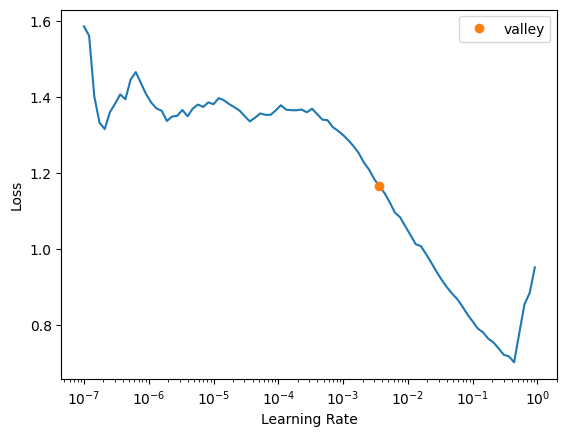

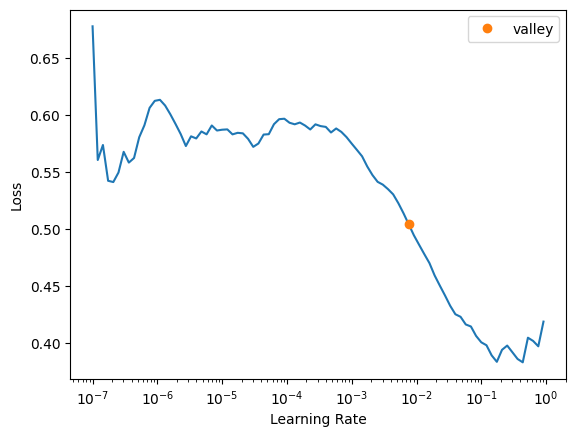

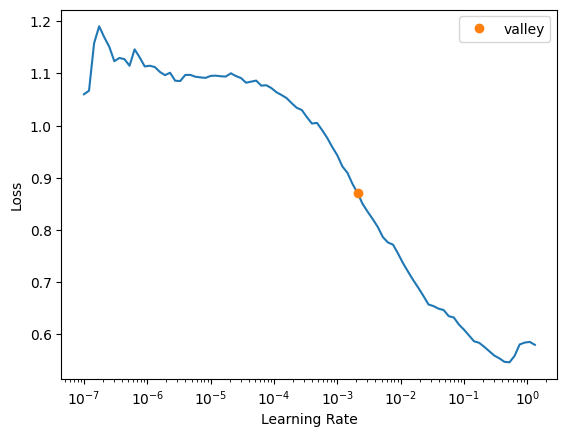

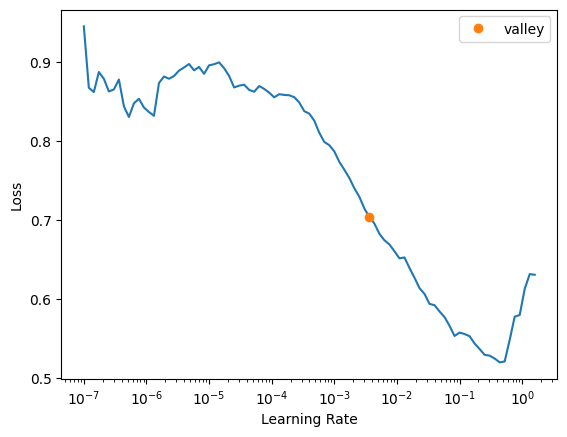

In [49]:
#Run the training and measure the time for each layer
for layer, learner in learners['NAG'].items():
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['NAG'][layer] = end-start



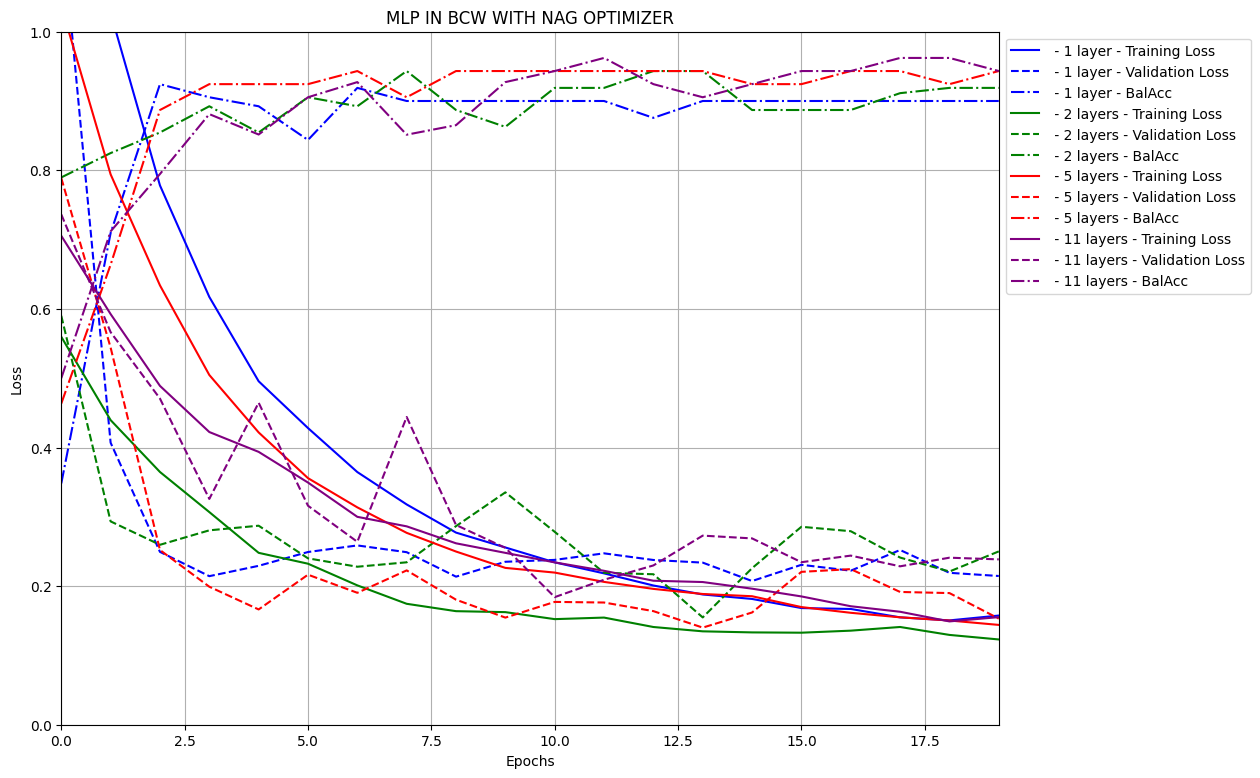

In [50]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['NAG'].values(), title='MLP IN BCW WITH NAG OPTIMIZER', names=names_layer, metric=metric)

### RMSProp

Better model found at epoch 0 with valid_loss value: 0.3120787739753723.
Better model found at epoch 2 with valid_loss value: 0.30783823132514954.
Better model found at epoch 4 with valid_loss value: 0.10759378224611282.


Better model found at epoch 0 with valid_loss value: 0.31305620074272156.
Better model found at epoch 2 with valid_loss value: 0.30378150939941406.
Better model found at epoch 3 with valid_loss value: 0.17537443339824677.
Better model found at epoch 7 with valid_loss value: 0.1417434811592102.
Better model found at epoch 12 with valid_loss value: 0.13376829028129578.


Better model found at epoch 0 with valid_loss value: 0.3989187180995941.
Better model found at epoch 1 with valid_loss value: 0.16928303241729736.
Better model found at epoch 5 with valid_loss value: 0.15037232637405396.
Better model found at epoch 13 with valid_loss value: 0.13637322187423706.
Better model found at epoch 18 with valid_loss value: 0.129111185669899.
Better model found at epoch 19 with valid_loss value: 0.12131433933973312.


Better model found at epoch 0 with valid_loss value: 1.0013339519500732.
Better model found at epoch 2 with valid_loss value: 0.7803618311882019.
Better model found at epoch 3 with valid_loss value: 0.304146409034729.
Better model found at epoch 4 with valid_loss value: 0.15001174807548523.
Better model found at epoch 7 with valid_loss value: 0.12245559692382812.


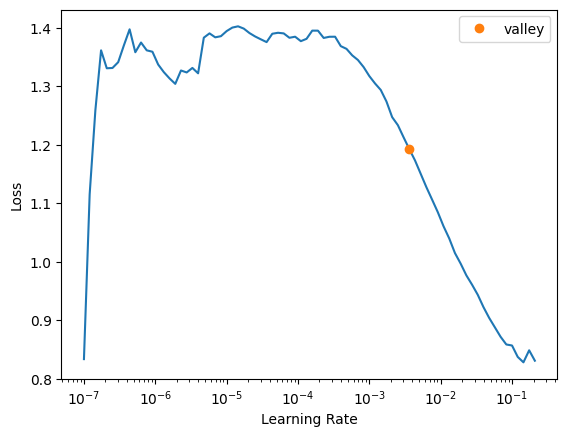

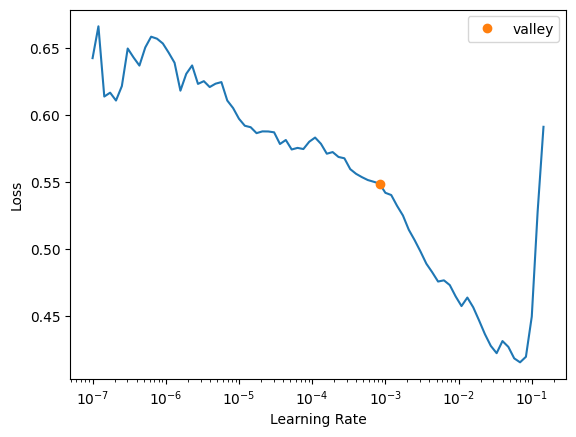

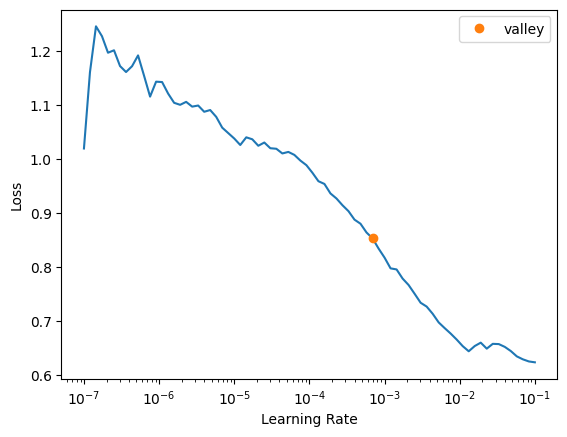

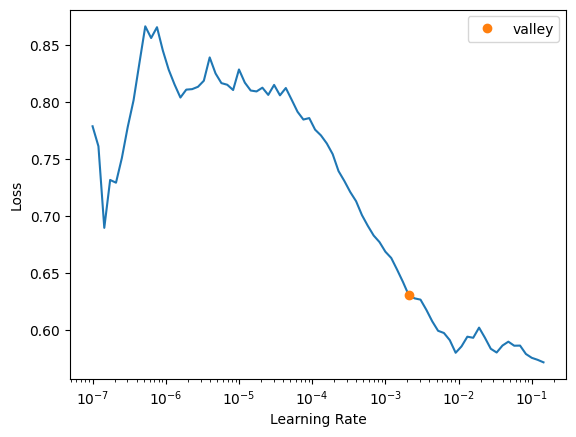

In [51]:
#Run the training and measure the time for each layer
for layer, learner in learners['RMSProp'].items():
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['RMSProp'][layer] = end-start


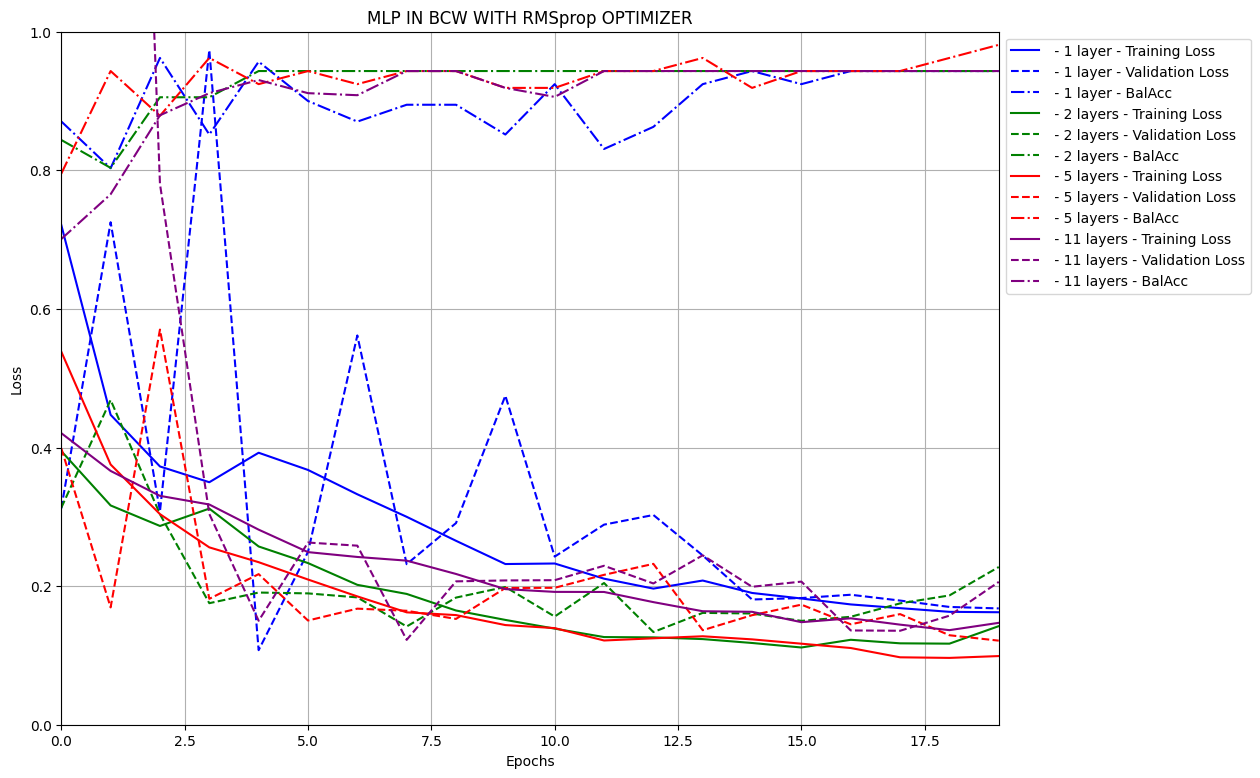

In [52]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['RMSProp'].values(), title='MLP IN BCW WITH RMSprop OPTIMIZER', names=names_layer, metric=metric)

### Adam

Better model found at epoch 0 with valid_loss value: 0.9052185416221619.
Better model found at epoch 1 with valid_loss value: 0.36149078607559204.
Better model found at epoch 2 with valid_loss value: 0.23473885655403137.
Better model found at epoch 4 with valid_loss value: 0.23335982859134674.
Better model found at epoch 5 with valid_loss value: 0.22733716666698456.
Better model found at epoch 10 with valid_loss value: 0.19878672063350677.
Better model found at epoch 11 with valid_loss value: 0.1725267469882965.
Better model found at epoch 14 with valid_loss value: 0.14018607139587402.


Better model found at epoch 0 with valid_loss value: 0.5009539723396301.
Better model found at epoch 1 with valid_loss value: 0.2819548547267914.
Better model found at epoch 5 with valid_loss value: 0.22786755859851837.
Better model found at epoch 6 with valid_loss value: 0.11204534024000168.


Better model found at epoch 0 with valid_loss value: 0.6849046945571899.
Better model found at epoch 1 with valid_loss value: 0.3362320363521576.
Better model found at epoch 2 with valid_loss value: 0.264406681060791.
Better model found at epoch 4 with valid_loss value: 0.20399209856987.
Better model found at epoch 5 with valid_loss value: 0.13360635936260223.
Better model found at epoch 17 with valid_loss value: 0.13308854401111603.


Better model found at epoch 0 with valid_loss value: 0.7477657794952393.
Better model found at epoch 1 with valid_loss value: 0.5824589133262634.
Better model found at epoch 4 with valid_loss value: 0.29814958572387695.
Better model found at epoch 7 with valid_loss value: 0.20014820992946625.
Better model found at epoch 8 with valid_loss value: 0.1728459596633911.


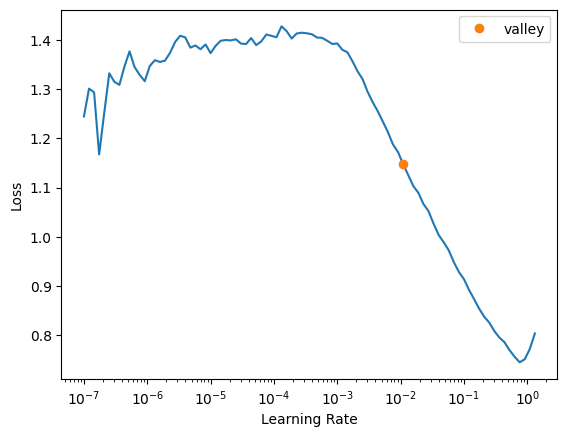

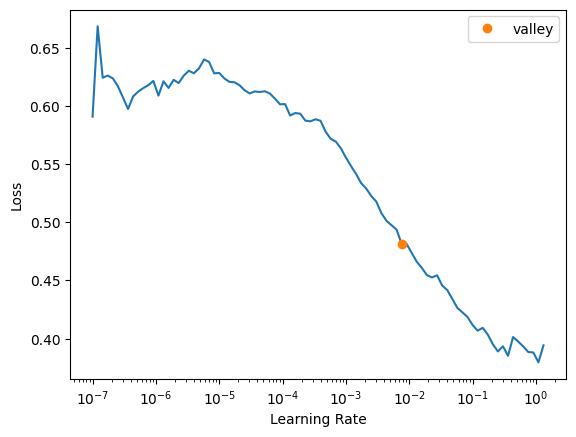

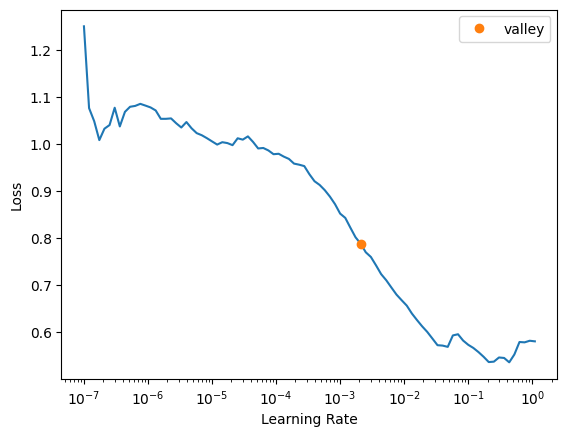

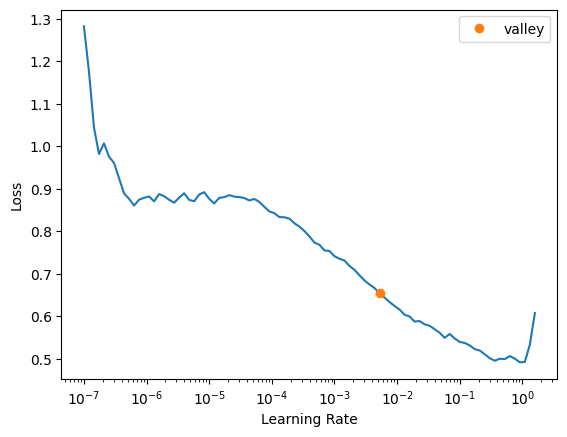

In [53]:
#Run the training and measure the time for each layer
for layer, learner in learners['ADAM'].items():
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['ADAM'][layer] = end-start


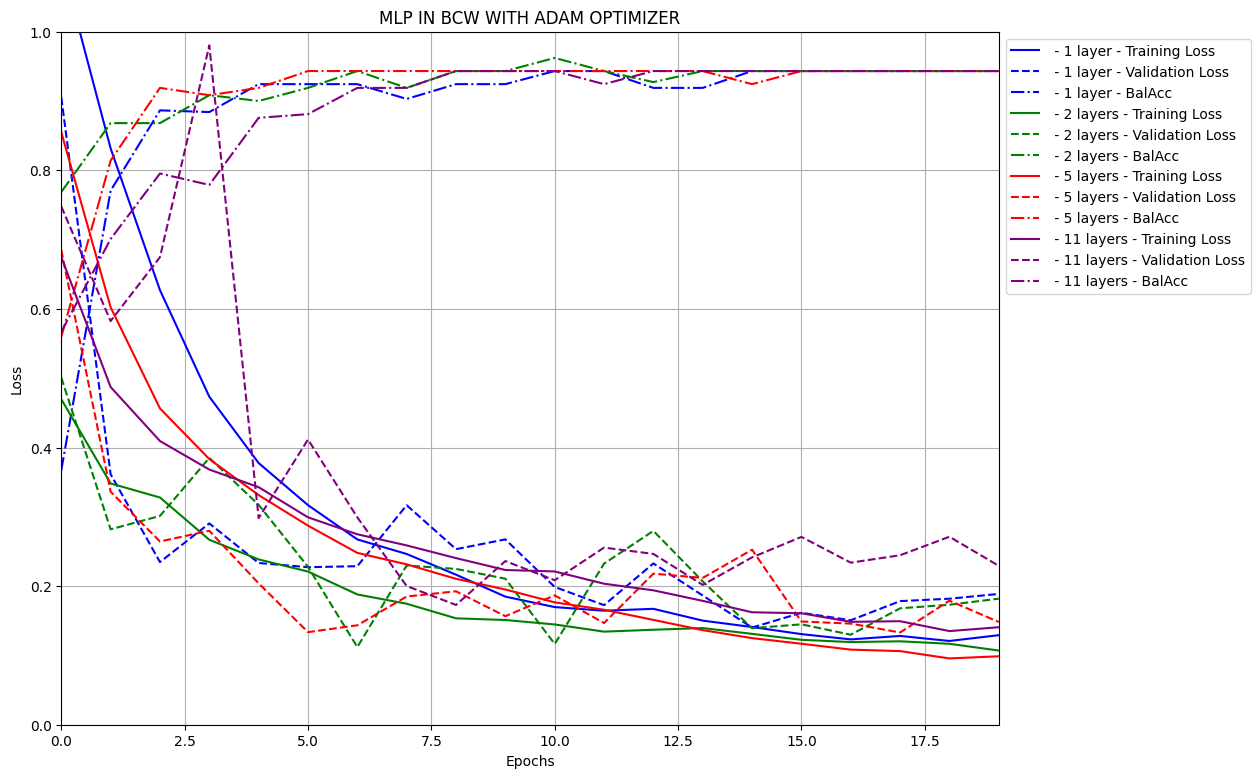

In [54]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['ADAM'].values(), title='MLP IN BCW WITH ADAM OPTIMIZER', names=names_layer, metric=metric)

### Save or Load models

In [55]:
#Save learner with their losses and metrics
for optim in optims:
  for layer in n_layers:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{layer}_{optim}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump({'learner': learners[optim][layer], 'recorder_values': learners[optim][layer].recorder.values}, f)


In [56]:
#Load learner with their losses and metrics
for optim in optims:
  for layer in n_layers:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{layer}_{optim}.pkl'
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    learners[optim][layer], learners[optim][layer].recorder.values = data['learner'], data['recorder_values']

### Comparative per layers

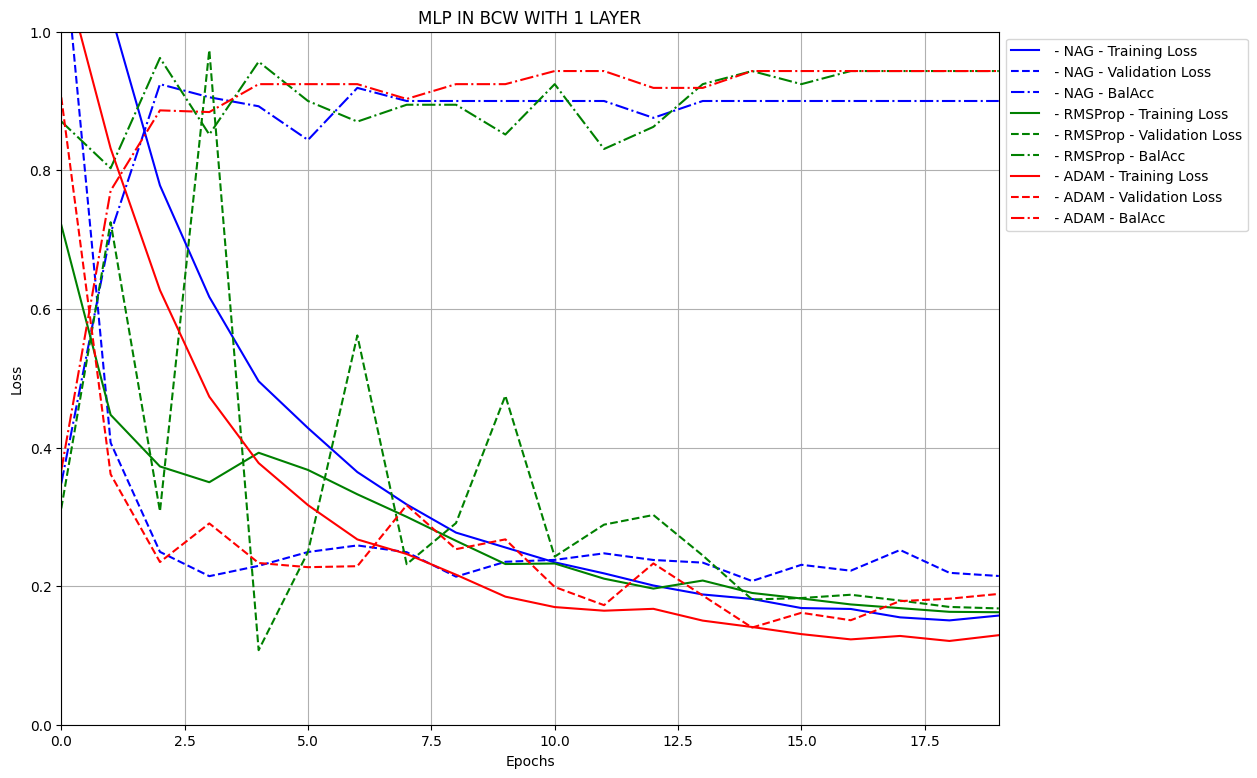

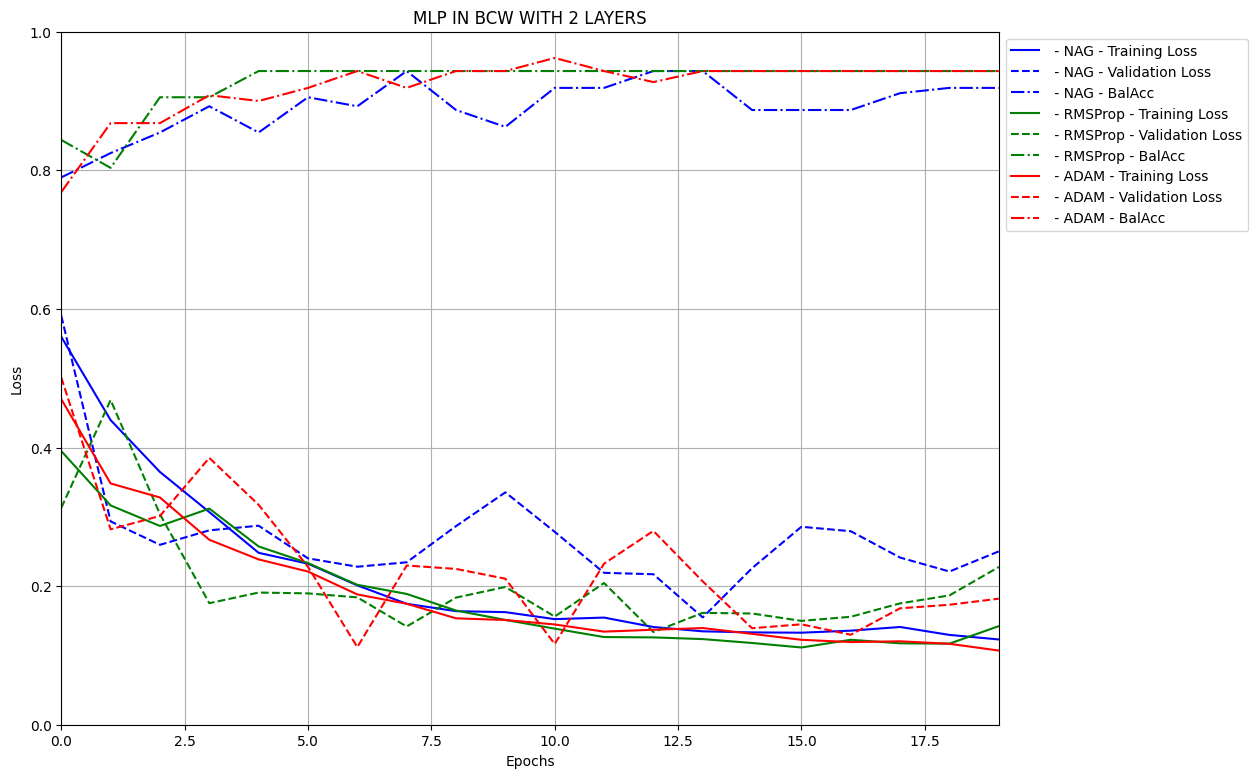

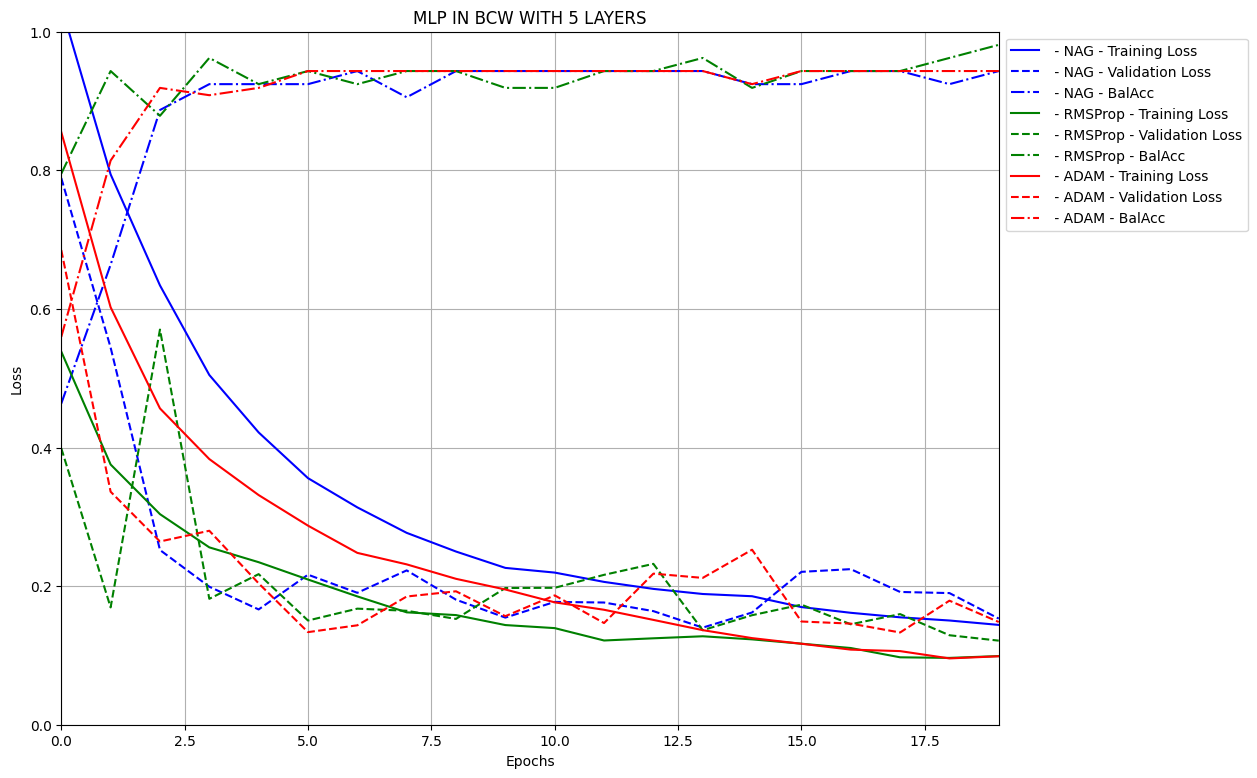

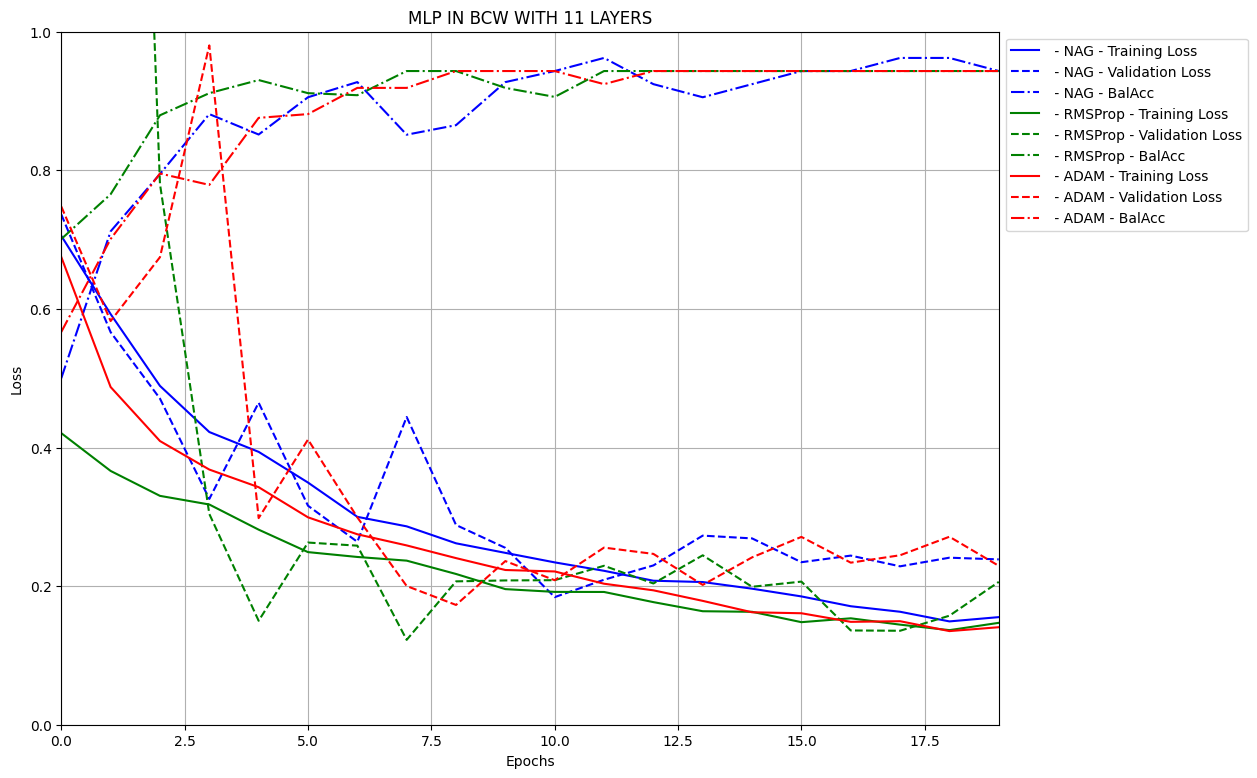

In [57]:
#Compare the three optimizers for each layer

learners_1_layer = [learners['NAG'][1], learners['RMSProp'][1], learners['ADAM'][1]]
learners_2_layers = [learners['NAG'][2], learners['RMSProp'][2], learners['ADAM'][2]]
learners_5_layers = [learners['NAG'][5], learners['RMSProp'][5], learners['ADAM'][5]]
learners_11_layers = [learners['NAG'][11], learners['RMSProp'][11], learners['ADAM'][11]]

names=['NAG', 'RMSProp', 'ADAM']
utilsTFG.plot_learners_training(learners_1_layer, title='MLP IN BCW WITH 1 LAYER', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_2_layers, title='MLP IN BCW WITH 2 LAYERS', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_5_layers, title='MLP IN BCW WITH 5 LAYERS', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_11_layers, title='MLP IN BCW WITH 11 LAYERS', names=names, metric=metric)

### Generalization

In [58]:
#Run the model in the test set
for optim in optims:
  for layer in n_layers:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    learners[optim][layer].model.eval()
    learners[optim][layer].eval()
    preds, targs = learners[optim][layer].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    # Calculate bal_accuracy
    accuracy = utilsTFG.balanced_accuracy_func(preds, targs)

    #Calculate loss
    loss = utilsTFG.err_param_w_model(learners[optim][layer].model, test_dl, mode = 'test')


    print(f"Optimizer: {optim}, Layers: {layer}, Loss: {loss}, Balanced Accuracy: {accuracy}")

Optimizer: NAG, Layers: 1, Loss: 0.12250494956970215, Balanced Accuracy: 0.9347826086956521


Optimizer: NAG, Layers: 2, Loss: 0.09201680123806, Balanced Accuracy: 0.9456521739130435


Optimizer: NAG, Layers: 5, Loss: 0.09886651486158371, Balanced Accuracy: 0.9565217391304348


Optimizer: NAG, Layers: 11, Loss: 0.1448824405670166, Balanced Accuracy: 0.9509978617248753


Optimizer: RMSProp, Layers: 1, Loss: 0.47313499450683594, Balanced Accuracy: 0.882751247327156


Optimizer: RMSProp, Layers: 2, Loss: 0.0678846463561058, Balanced Accuracy: 0.9673913043478262


Optimizer: RMSProp, Layers: 5, Loss: 0.05680880323052406, Balanced Accuracy: 0.9591945830363506


Optimizer: RMSProp, Layers: 11, Loss: 0.10106411576271057, Balanced Accuracy: 0.9456521739130435


Optimizer: ADAM, Layers: 1, Loss: 0.07977776974439621, Balanced Accuracy: 0.9565217391304348


Optimizer: ADAM, Layers: 2, Loss: 0.07758381962776184, Balanced Accuracy: 0.9456521739130435


Optimizer: ADAM, Layers: 5, Loss: 0.07465317100286484, Balanced Accuracy: 0.9565217391304348


Optimizer: ADAM, Layers: 11, Loss: 0.17968162894248962, Balanced Accuracy: 0.9347826086956521


## Metaheuristics

In [59]:
#Initialise dictionaries
pop_size=10
population = {}
fitness = {}
mh_learners = {}
results = {}
fitness_valid = {}
best = {}
time_mh = {}

#Initialise the population to have the same values for all the MH
for n_layer,layer in zip(n_layers,layers):
  population[n_layer] = []
  fitness[n_layer] = []
  mh_learners[n_layer] = tabular_learner(dls, layers=layer, cbs=[SaveModelCallback()])
  mh_learners[n_layer].to(device)
  mh_learners[n_layer].model.to(device)
  for _ in range(pop_size):
    model_copy = copy.deepcopy(mh_learners[n_layer].model)

    # Reset the weights of the model copy
    model_copy.apply(utilsTFG.init_weights_glorot)

    # Add the reinitialized model to the population list
    population[n_layer].append(utilsTFG.get_params_from_model(model_copy))

    fitness[n_layer].append(utilsTFG.err_param_w_model(model_copy, dls))

#More initialisation
for alg in algs:
  results[alg] = {}
  fitness_valid[alg] = {}
  best[alg] = {}
  time_mh[alg] = {}

max_evals=4200
max_evals_shade=200
max_ls=5


### Genetic Algorithms

In [60]:
#Genetic Algorithm working as supposed to (terrible performance)
#results['GA'] = {}
#for layer in n_layers:
#  start = time.perf_counter()
#  results['GA'][layer] = utilsTFG.gen_alg(pop_size, copy.deepcopy(population[layer]), fitness[layer], dls, 4000, mh_learners[layer])
#  end = time.perf_counter()
#  time_mh['GA'][layer] = end-start

### SHADE

In [61]:
#Runing SHADE algorithm

results['SHADE'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE'][layer] = utilsTFG.SHADE_ej(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), pop_size,max_evals, len(population[layer][0]), dls,  model=mh_learners[layer].model)
  end = time.perf_counter()
  time_mh['SHADE'][layer] = end-start


In [62]:
#Validate the models obtained.
fitness_valid['SHADE'] = {}
for layer in n_layers:
  fitness_valid['SHADE'][layer] = []
  for ind in results['SHADE'][layer][5]:
    fitness_valid['SHADE'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [63]:
#compare train and valid and select the best generalizing model.
for layer in n_layers:
  print(f"Training error of SHADE for {layer} layers: {results['SHADE'][layer][6]}")
  print(f"Validation error of SHADE for {layer} layers: {fitness_valid['SHADE'][layer]}")
  dif = np.array(fitness_valid['SHADE'][layer]) - np.array(results['SHADE'][layer][6])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE'][layer])
  best['SHADE'][layer] = results['SHADE'][layer][5][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")

  print("\n")

Training error of SHADE for 1 layers: [0.6987293362617493, 0.5312157869338989, 0.42889222502708435, 0.3151615262031555, 0.3151615262031555, 0.2962872087955475, 0.24840974807739258, 0.21955956518650055, 0.19783133268356323, 0.19783133268356323, 0.19783133268356323, 0.1962260752916336, 0.1962260752916336, 0.1962260752916336, 0.15856142342090607, 0.15856142342090607, 0.15856142342090607, 0.15856142342090607, 0.15856142342090607, 0.15856142342090607, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692676305771, 0.1395692

### SHADE-ILS

In [65]:
# Running SHADE-ILS algorithm
results['SHADE-ILS'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE-ILS'][layer] = utilsTFG.SHADE_ILS(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS'][layer] = end-start


eo
deque([1, 0.8022652439495125, 0.0], maxlen=3)
deque([0.8022652439495125, 0.0, -0.31220829409768175], maxlen=3)
232
eo
deque([0.0, -0.31220829409768175, 0.28146961489804345], maxlen=3)
deque([-0.31220829409768175, 0.28146961489804345, -0.4843442385830264], maxlen=3)
444
eo
deque([0.28146961489804345, -0.4843442385830264, 0.3952727357636621], maxlen=3)
deque([-0.4843442385830264, 0.3952727357636621, -1.0507061989669801], maxlen=3)
655
eo
deque([0.3952727357636621, -1.0507061989669801, 0.5449523479403843], maxlen=3)
deque([-1.0507061989669801, 0.5449523479403843, -1.0488353319104164], maxlen=3)
866
eo
deque([0.5449523479403843, -1.0488353319104164, 0.44599733708579925], maxlen=3)
deque([-1.0488353319104164, 0.44599733708579925, -0.860151948491319], maxlen=3)
1077
eo
deque([0.44599733708579925, -0.860151948491319, 0.456129119552861], maxlen=3)
deque([-0.860151948491319, 0.456129119552861, -0.46773798036500996], maxlen=3)
1288
eo
deque([0.456129119552861, -0.46773798036500996, 0.29171402

In [68]:
#Validation error
fitness_valid['SHADE-ILS'] = {}
for layer in n_layers:
  fitness_valid['SHADE-ILS'][layer] = []
  for ind in results['SHADE-ILS'][layer][3]:
    fitness_valid['SHADE-ILS'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [69]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-ILS for {layer} layers: {results['SHADE-ILS'][layer][2]}")
  print(f"Validation error of SHADE-ILS for {layer} layers: {fitness_valid['SHADE-ILS'][layer]}")
  dif = np.array(fitness_valid['SHADE-ILS'][layer]) - np.array(results['SHADE-ILS'][layer][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS'][layer])
  best['SHADE-ILS'][layer] = results['SHADE-ILS'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS for 1 layers: [0.6987293362617493, 0.13816307485103607, 0.13816307485103607, 0.13816307485103607, 0.13816307485103607, 0.13816307485103607, 0.13816307485103607, 0.13816307485103607, 0.13816307485103607, 0.13816307485103607, 0.13816307485103607, 0.13816307485103607, 0.13816307485103607, 0.13816307485103607, 0.13816307485103607, 0.13816307485103607, 0.13816307485103607, 0.13816307485103607, 0.13816307485103607, 0.13816307485103607, 0.13816307485103607, 0.13816307485103607]
Validation error of SHADE-ILS for 1 layers: [0.5547376871109009, 0.2128545492887497, 0.2128545492887497, 0.2128545492887497, 0.2128545492887497, 0.2128545492887497, 0.2128545492887497, 0.2128545492887497, 0.2128545492887497, 0.2128545492887497, 0.2128545492887497, 0.2128545492887497, 0.2128545492887497, 0.2128545492887497, 0.2128545492887497, 0.2128545492887497, 0.2128545492887497, 0.2128545492887497, 0.2128545492887497, 0.2128545492887497, 0.2128545492887497, 0.2128545492887497]
Difference:

### SHADE-GD

eo
deque([1, 1, 0.6233200056676204], maxlen=3)
deque([1, 1, 0.6233200056676204], maxlen=3)
eo
deque([1, 0.6233200056676204, 0.1796852335938949], maxlen=3)
deque([1, 0.6233200056676204, 0.1796852335938949], maxlen=3)
eo
deque([0.6233200056676204, 0.1796852335938949, 0.0], maxlen=3)
deque([0.6233200056676204, 0.1796852335938949, 0.0], maxlen=3)
eo
deque([0.1796852335938949, 0.0, 0.043843869585436464], maxlen=3)
deque([0.1796852335938949, 0.0, 0.043843869585436464], maxlen=3)
eo
deque([0.0, 0.043843869585436464, 0.09603497480377128], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.2054503858089447.
deque([0.043843869585436464, 0.09603497480377128, -0.14322503689891342], maxlen=3)
eo
deque([0.09603497480377128, -0.14322503689891342, 0.12528157823364544], maxlen=3)
deque([0.09603497480377128, -0.14322503689891342, 0.12528157823364544], maxlen=3)
eo
deque([-0.14322503689891342, 0.12528157823364544, 0.0], maxlen=3)
deque([-0.14322503689891342, 0.12528157823364544, 0.0], maxlen=3)
eo
deque([0.12528157823364544, 0.0, 0.0], maxlen=3)
deque([0.12528157823364544, 0.0, 0.0], maxlen=3)
eo
deque([0.0, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.8168994351588263], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.2468484491109848.
deque([1, 0.8168994351588263, 0.059996184823362386], maxlen=3)
eo
deque([0.8168994351588263, 0.059996184823362386, 0.24043369232915074], maxlen=3)
deque([0.8168994351588263, 0.059996184823362386, 0.24043369232915074], maxlen=3)
eo
deque([0.059996184823362386, 0.24043369232915074, 0.23258923709039886], maxlen=3)
deque([0.059996184823362386, 0.24043369232915074, 0.23258923709039886], maxlen=3)
eo
deque([0.24043369232915074, 0.23258923709039886, 0.05114070204111142], maxlen=3)
deque([0.24043369232915074, 0.23258923709039886, 0.05114070204111142], maxlen=3)
eo
deque([0.23258923709039886, 0.05114070204111142, 0.0], maxlen=3)
deque([0.23258923709039886, 0.05114070204111142, 0.0], maxlen=3)
eo
deque([0.05114070204111142, 0.0, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.365149587392807.
deque([0.0, 0.0, -0.7191768745776881], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.7671963120228377], maxlen=3)
deque([1, 1, 0.7671963120228377], maxlen=3)
eo
deque([1, 0.7671963120228377, 0.3970830940597711], maxlen=3)
deque([1, 0.7671963120228377, 0.3970830940597711], maxlen=3)
eo
deque([0.7671963120228377, 0.3970830940597711, 0.08043756394869746], maxlen=3)
deque([0.7671963120228377, 0.3970830940597711, 0.08043756394869746], maxlen=3)
eo
deque([0.3970830940597711, 0.08043756394869746, 0.03985006051251249], maxlen=3)
deque([0.3970830940597711, 0.08043756394869746, 0.03985006051251249], maxlen=3)
eo
deque([0.08043756394869746, 0.03985006051251249, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.22341547906398773.
deque([0.03985006051251249, 0.0, -1.09244656444774], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.5533817134474712], maxlen=3)
deque([1, 1, 0.5533817134474712], maxlen=3)
eo
deque([1, 1, 0.3161667807087858], maxlen=3)
deque([1, 1, 0.3161667807087858], maxlen=3)
eo
deque([1, 0.3161667807087858, 0.213365031379744], maxlen=3)
deque([1, 0.3161667807087858, 0.213365031379744], maxlen=3)
eo
deque([0.3161667807087858, 0.213365031379744, 0.21656719215679193], maxlen=3)
deque([0.3161667807087858, 0.213365031379744, 0.21656719215679193], maxlen=3)
eo
deque([0.213365031379744, 0.21656719215679193, 0.0], maxlen=3)
deque([0.213365031379744, 0.21656719215679193, 0.0], maxlen=3)
eo
deque([0.21656719215679193, 0.0, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.8484892249107361.
deque([0.0, 0.0, -0.06159825180226982], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.8056550099536917], maxlen=3)
deque([1, 1, 0.8056550099536917], maxlen=3)
eo
deque([1, 0.8056550099536917, 0.12934272524728677], maxlen=3)
deque([1, 0.8056550099536917, 0.12934272524728677], maxlen=3)
eo
deque([0.8056550099536917, 0.12934272524728677, 0.0], maxlen=3)
deque([0.8056550099536917, 0.12934272524728677, 0.0], maxlen=3)
eo
deque([0.12934272524728677, 0.0, 0.08967660133682233], maxlen=3)
deque([0.12934272524728677, 0.0, 0.08967660133682233], maxlen=3)
eo
deque([0.0, 0.08967660133682233, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.571388840675354.
deque([0.08967660133682233, 0.0, -0.08883102161666398], maxlen=3)
eo
deque([0.0, -0.08883102161666398, 0.21277795979529976], maxlen=3)
deque([0.0, -0.08883102161666398, 0.21277795979529976], maxlen=3)
eo
deque([-0.08883102161666398, 0.21277795979529976, 0.18085484679772418], maxlen=3)
deque([-0.08883102161666398, 0.21277795979529976, 0.18085484679772418], maxlen=3)
eo
deque([0.21277795979529976, 0.18085484679772418, 0.03315881581332363], maxlen=3)
deque([0.21277795979529976, 0.18085484679772418, 0.03315881581332363], maxlen=3)
eo
deque([0.18085484679772418, 0.03315881581332363, 0.08241958032183172], maxlen=3)
deque([0.18085484679772418, 0.03315881581332363, 0.08241958032183172], maxlen=3)
eo
deque([0.03315881581332363, 0.08241958032183172, 0.026290436235082638], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.22052404284477234.
deque([0.08241958032183172, 0.026290436235082638, -0.09215061368801927], maxlen=3)
eo
deque([0.026290436235082638, -0.09215061368801927, 0.25185347469277974], maxlen=3)
deque([0.026290436235082638, -0.09215061368801927, 0.25185347469277974], maxlen=3)
eo
deque([-0.09215061368801927, 0.25185347469277974, 0.0], maxlen=3)
deque([-0.09215061368801927, 0.25185347469277974, 0.0], maxlen=3)
eo
deque([0.25185347469277974, 0.0, 0.052231371385933895], maxlen=3)
deque([0.25185347469277974, 0.0, 0.052231371385933895], maxlen=3)
eo
deque([0.0, 0.052231371385933895, 0.0], maxlen=3)
deque([0.0, 0.052231371385933895, 0.0], maxlen=3)
eo
deque([0.052231371385933895, 0.0, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.32979923486709595.
deque([0.0, 0.0, -0.9618180997926598], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.8275150145801118], maxlen=3)
deque([1, 1, 0.8275150145801118], maxlen=3)
eo
deque([1, 1, 0.29400242533979504], maxlen=3)
deque([1, 1, 0.29400242533979504], maxlen=3)
eo
deque([1, 0.29400242533979504, 0.2031702228211965], maxlen=3)
deque([1, 0.29400242533979504, 0.2031702228211965], maxlen=3)
eo
deque([0.29400242533979504, 0.2031702228211965, 0.0], maxlen=3)
deque([0.29400242533979504, 0.2031702228211965, 0.0], maxlen=3)
eo
deque([0.2031702228211965, 0.0, 0.0], maxlen=3)
deque([0.2031702228211965, 0.0, 0.0], maxlen=3)
eo
deque([0.0, 0.0, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.6275461316108704.
deque([0.0, 0.0, 0.4606647943825392], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.6268489394571044], maxlen=3)
deque([1, 1, 0.6268489394571044], maxlen=3)
eo
deque([1, 0.6268489394571044, 0.1688554288168], maxlen=3)
deque([1, 0.6268489394571044, 0.1688554288168], maxlen=3)
eo
deque([0.6268489394571044, 0.1688554288168, 0.04161434446775571], maxlen=3)
deque([0.6268489394571044, 0.1688554288168, 0.04161434446775571], maxlen=3)
eo
deque([0.1688554288168, 0.04161434446775571, 0.18217114286008995], maxlen=3)
deque([0.1688554288168, 0.04161434446775571, 0.18217114286008995], maxlen=3)
eo
deque([0.04161434446775571, 0.18217114286008995, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5803838968276978.
deque([0.18217114286008995, 0.0, -0.17786295844706915], maxlen=3)
eo
deque([0.0, -0.17786295844706915, 0.15100479828448732], maxlen=3)
deque([0.0, -0.17786295844706915, 0.15100479828448732], maxlen=3)
eo
deque([-0.17786295844706915, 0.15100479828448732, 0.0], maxlen=3)
deque([-0.17786295844706915, 0.15100479828448732, 0.0], maxlen=3)
eo
deque([0.15100479828448732, 0.0, 0.0], maxlen=3)
deque([0.15100479828448732, 0.0, 0.0], maxlen=3)
eo
deque([0.0, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.780043968028481], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5083101987838745.
deque([1, 0.780043968028481, 0.4179849679035709], maxlen=3)
eo
deque([0.780043968028481, 0.4179849679035709, 0.3157450176415229], maxlen=3)
deque([0.780043968028481, 0.4179849679035709, 0.3157450176415229], maxlen=3)
eo
deque([0.4179849679035709, 0.3157450176415229, 0.0], maxlen=3)
deque([0.4179849679035709, 0.3157450176415229, 0.0], maxlen=3)
eo
deque([0.3157450176415229, 0.0, 0.0], maxlen=3)
deque([0.3157450176415229, 0.0, 0.0], maxlen=3)
eo
deque([0.0, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.7601940550581934], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5032798647880554.
deque([1, 0.7601940550581934, 0.3677373107471119], maxlen=3)
eo
deque([0.7601940550581934, 0.3677373107471119, 0.31448839414265406], maxlen=3)
deque([0.7601940550581934, 0.3677373107471119, 0.31448839414265406], maxlen=3)
eo
deque([1, 1, 0.1109665823937852], maxlen=3)
deque([1, 1, 0.1109665823937852], maxlen=3)
eo
deque([1, 0.1109665823937852, 0.12003742528792234], maxlen=3)
deque([1, 0.1109665823937852, 0.12003742528792234], maxlen=3)
eo
deque([0.1109665823937852, 0.12003742528792234, 0.0], maxlen=3)
deque([0.1109665823937852, 0.12003742528792234, 0.0], maxlen=3)
eo
deque([0.12003742528792234, 0.0, 0.0], maxlen=3)
deque([0.12003742528792234, 0.0, 0.0], maxlen=3)
eo
deque([0.0, 0.0, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.15945149958133698.
deque([0.0, 0.0, 0.38599985860459146], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.48254238612002354], maxlen=3)
deque([1, 1, 0.48254238612002354], maxlen=3)
eo
deque([1, 0.48254238612002354, 0.0], maxlen=3)
deque([1, 0.48254238612002354, 0.0], maxlen=3)
eo
deque([0.48254238612002354, 0.0, 0.03802153507232942], maxlen=3)
deque([0.48254238612002354, 0.0, 0.03802153507232942], maxlen=3)
eo
deque([0.0, 0.03802153507232942, 0.0], maxlen=3)
deque([0.0, 0.03802153507232942, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.5356907851595111], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.5728533267974854.
deque([1, 0.5356907851595111, 0.4440526737820119], maxlen=3)
eo
deque([0.5356907851595111, 0.4440526737820119, 0.1515786546012794], maxlen=3)
deque([0.5356907851595111, 0.4440526737820119, 0.1515786546012794], maxlen=3)
eo
deque([0.4440526737820119, 0.1515786546012794, 0.06800208668519835], maxlen=3)
deque([0.4440526737820119, 0.1515786546012794, 0.06800208668519835], maxlen=3)
eo
deque([0.1515786546012794, 0.06800208668519835, 0.011955587202752457], maxlen=3)
deque([0.1515786546012794, 0.06800208668519835, 0.011955587202752457], maxlen=3)
eo
deque([0.06800208668519835, 0.011955587202752457, 0.0], maxlen=3)
deque([0.06800208668519835, 0.011955587202752457, 0.0], maxlen=3)
eo
deque([0.011955587202752457, 0.0, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 8.49321174621582.
deque([0.0, 0.0, -0.4135377406663408], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.5302919207903236], maxlen=3)
deque([1, 1, 0.5302919207903236], maxlen=3)
eo
deque([1, 0.5302919207903236, 0.07412678441955926], maxlen=3)
deque([1, 0.5302919207903236, 0.07412678441955926], maxlen=3)
eo
deque([0.5302919207903236, 0.07412678441955926, 0.06533780562488709], maxlen=3)
deque([0.5302919207903236, 0.07412678441955926, 0.06533780562488709], maxlen=3)
eo
deque([0.07412678441955926, 0.06533780562488709, 0.0], maxlen=3)
deque([0.07412678441955926, 0.06533780562488709, 0.0], maxlen=3)
eo
deque([0.06533780562488709, 0.0, 0.0], maxlen=3)


Better model found at epoch 0 with valid_loss value: 3.7813494205474854.
deque([0.0, 0.0, 0.3543923474375477], maxlen=3)
eo
deque([0.0, 0.3543923474375477, 0.2987120386771314], maxlen=3)
deque([0.0, 0.3543923474375477, 0.2987120386771314], maxlen=3)


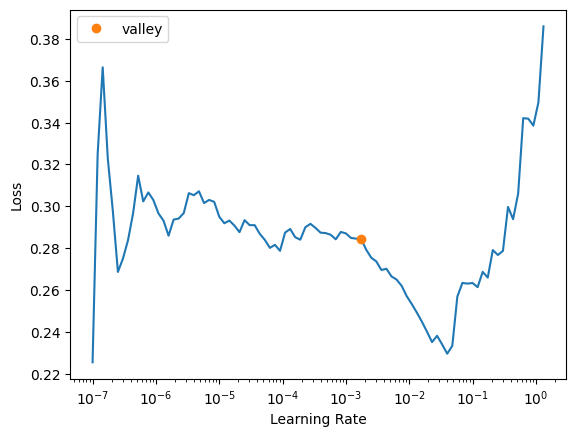

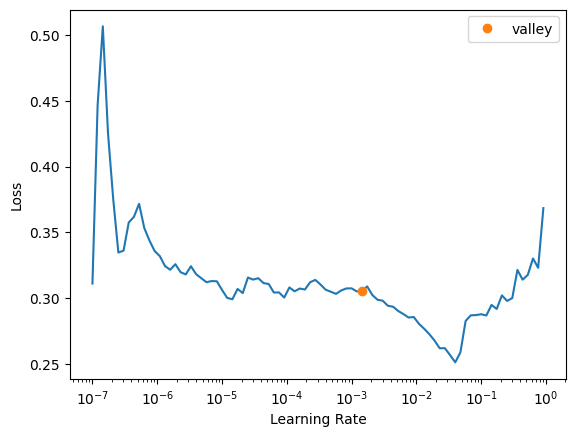

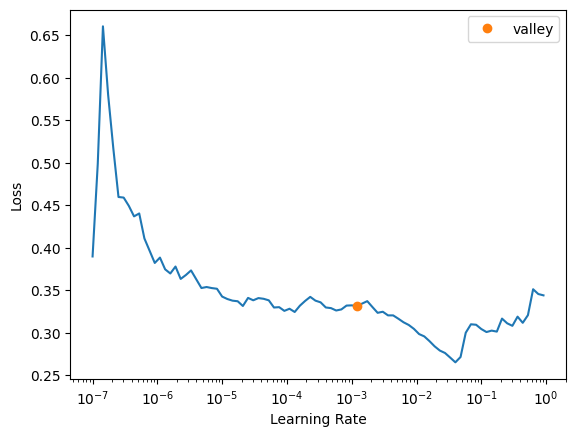

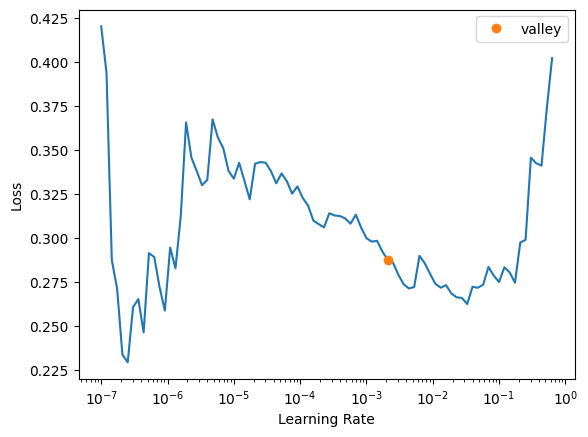

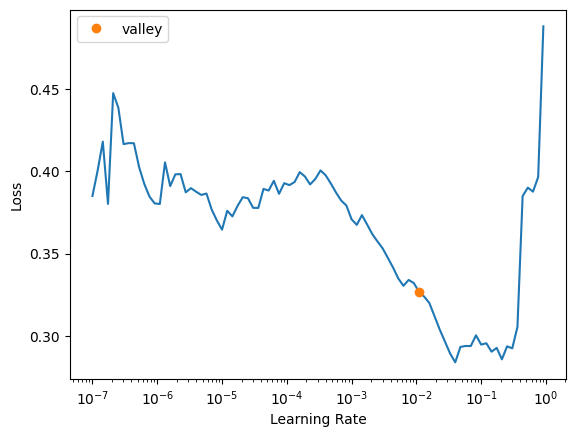

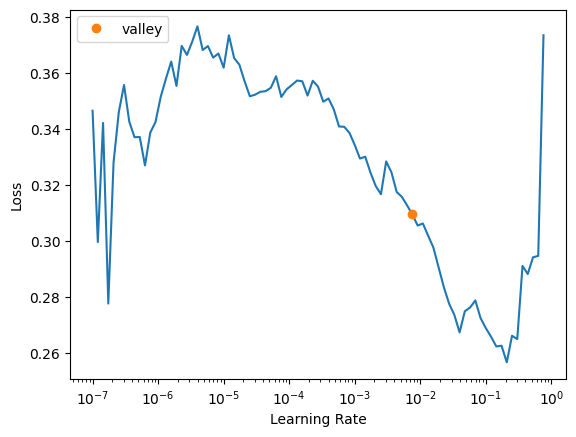

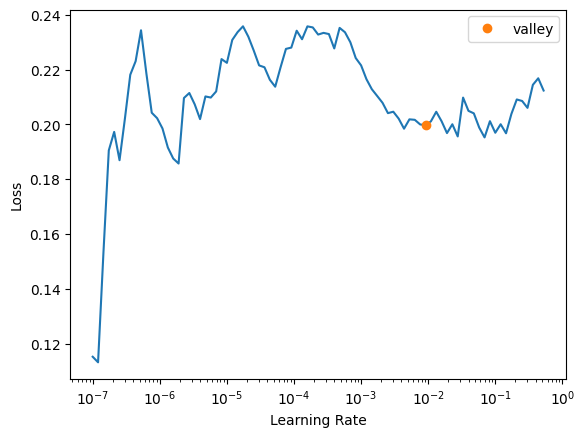

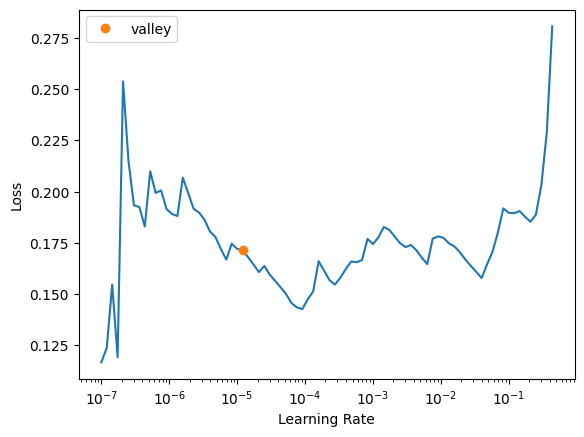

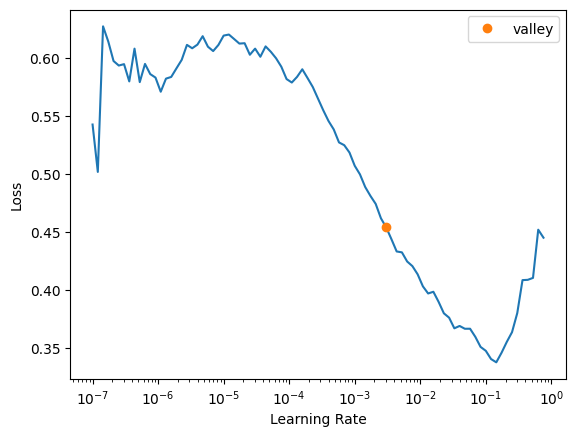

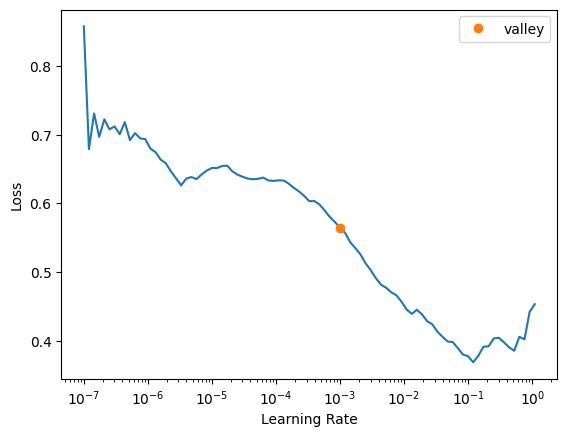

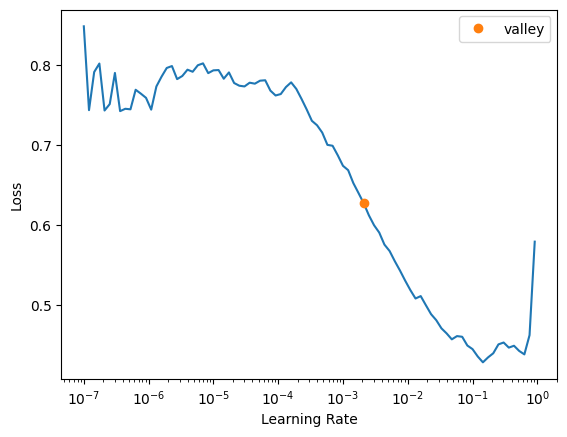

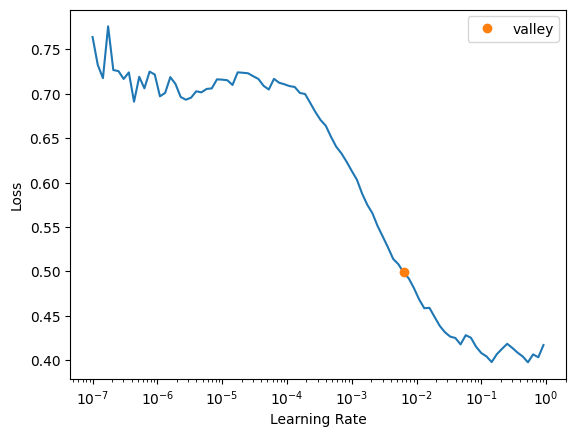

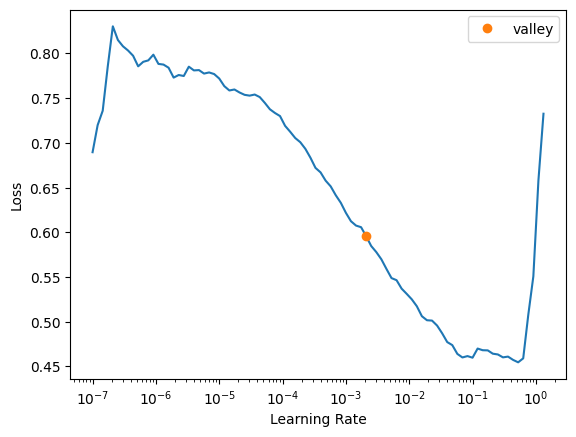

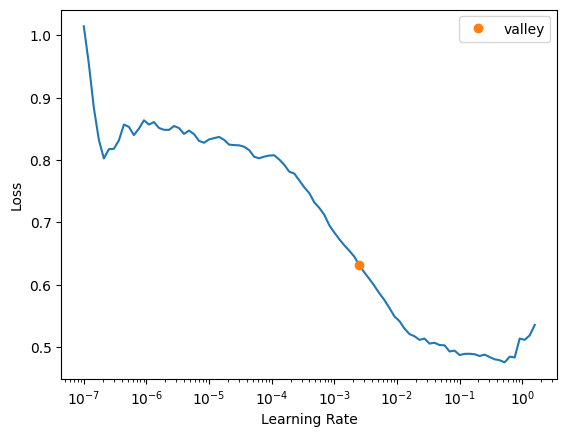

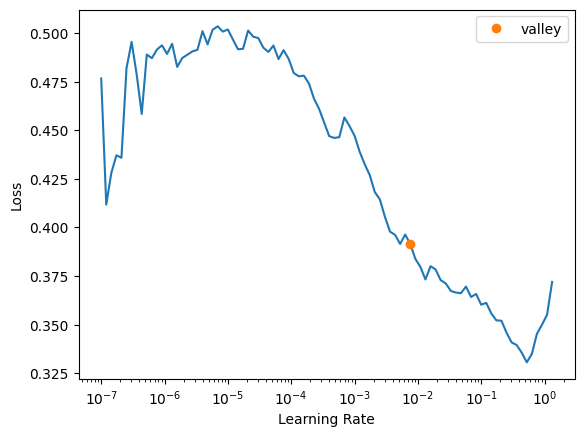

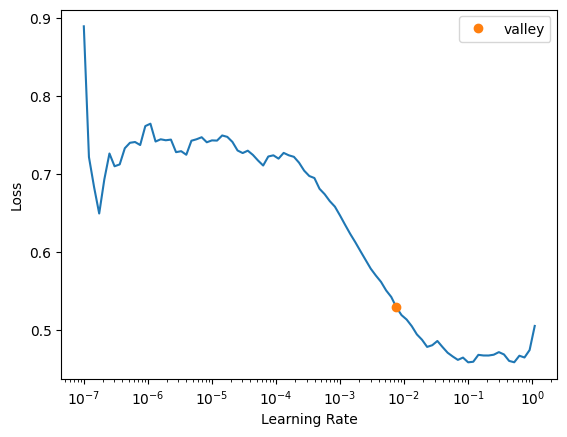

In [70]:
# Running SHADE algorithm with GD
results['SHADE-GD'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE-GD'][layer] = utilsTFG.SHADE_GD(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model)
  end = time.perf_counter()
  time_mh['SHADE-GD'][layer] = end-start


In [71]:
#Validation error
fitness_valid['SHADE-GD'] = {}
for layer in n_layers:
  fitness_valid['SHADE-GD'][layer] = []
  for ind in results['SHADE-GD'][layer][3]:
    fitness_valid['SHADE-GD'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [72]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-GD for {layer} layers: {results['SHADE-GD'][layer][2]}")
  print(f"Validation error of SHADE-GD for {layer} layers: {fitness_valid['SHADE-GD'][layer]}")
  dif = np.array(fitness_valid['SHADE-GD'][layer]) - np.array(results['SHADE-GD'][layer][2])
  print(f"Difference: {dif}")
  #mejor = np.argmin(dif)
  mejor = np.argmin(fitness_valid['SHADE-GD'][layer])
  best['SHADE-GD'][layer] = results['SHADE-GD'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-GD for 1 layers: [0.6987293362617493, 0.2631973624229431, 0.21590468287467957, 0.21590468287467957, 0.2064385861158371, 0.2064385861158371, 0.1866132616996765, 0.1866132616996765, 0.1866132616996765, 0.1866132616996765, 0.1866132616996765, 0.1866132616996765, 0.14509697258472443, 0.13767661154270172, 0.13767661154270172, 0.13767661154270172, 0.13767661154270172, 0.13767661154270172, 0.13767661154270172, 0.13767661154270172, 0.13767661154270172, 0.13767661154270172]
Validation error of SHADE-GD for 1 layers: [0.6989655494689941, 0.6449803709983826, 0.46058225631713867, 0.46058225631713867, 0.46195775270462036, 0.46195775270462036, 0.46185851097106934, 0.46185851097106934, 0.46185851097106934, 0.46185851097106934, 0.46185851097106934, 0.46185851097106934, 0.44744399189949036, 0.647525429725647, 0.647525429725647, 0.647525429725647, 0.647525429725647, 0.647525429725647, 0.647525429725647, 0.647525429725647, 0.647525429725647, 0.647525429725647]
Difference: [2.36213

### SHADE-ILS-GD

deque([1, 1, 0.7361664511168172], maxlen=3)
eo
deque([1, 0.7361664511168172, 0.11243512355633772], maxlen=3)
deque([0.7361664511168172, 0.11243512355633772, -0.040744157259544056], maxlen=3)
deque([0.11243512355633772, -0.040744157259544056, 0.0], maxlen=3)
eo
deque([-0.040744157259544056, 0.0, 0.2678148978513729], maxlen=3)
deque([0.0, 0.2678148978513729, -0.6826132628778688], maxlen=3)
deque([0.2678148978513729, -0.6826132628778688, 0.0], maxlen=3)
eo
deque([-0.6826132628778688, 0.0, 0.5422844654852566], maxlen=3)
deque([0.0, 0.5422844654852566, -0.8624889686307974], maxlen=3)
deque([0.5422844654852566, -0.8624889686307974, 0.0], maxlen=3)
eo
deque([-0.8624889686307974, 0.0, 0.48975354995972376], maxlen=3)
deque([0.0, 0.48975354995972376, -0.9267582326875117], maxlen=3)
deque([0.48975354995972376, -0.9267582326875117, 0.0], maxlen=3)
eo
deque([-0.9267582326875117, 0.0, 0.433829488646625], maxlen=3)
deque([0.0, 0.433829488646625, -0.2912120288362636], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.2053690105676651.
deque([0.433829488646625, -0.2912120288362636, -0.3734417172636872], maxlen=3)
eo
deque([-0.2912120288362636, -0.3734417172636872, 0.4803596782425987], maxlen=3)
deque([-0.3734417172636872, 0.4803596782425987, -0.9777088353056496], maxlen=3)
deque([0.4803596782425987, -0.9777088353056496, 0.0], maxlen=3)
eo
deque([-0.9777088353056496, 0.0, 0.5364037498740293], maxlen=3)
deque([0.0, 0.5364037498740293, -1.2584783308685412], maxlen=3)
deque([0.5364037498740293, -1.2584783308685412, 0.0], maxlen=3)
eo
deque([-1.2584783308685412, 0.0, 0.4720581263015804], maxlen=3)
deque([0.0, 0.4720581263015804, -0.7061474099370835], maxlen=3)
deque([0.4720581263015804, -0.7061474099370835, 0.0], maxlen=3)
eo
deque([-0.7061474099370835, 0.0, 0.484170384873365], maxlen=3)
deque([0.0, 0.484170384873365, -1.2109540605318878], maxlen=3)
deque([0.484170384873365, -1.2109540605318878, 0.0], maxlen=3)
eo
deque([-1.2109540605318878, 0.0, 0.4

Better model found at epoch 0 with valid_loss value: 0.1450044959783554.
deque([0.41428869562986326, -0.5112016941160028, -0.038566470457813945], maxlen=3)
eo
deque([-0.5112016941160028, -0.038566470457813945, 0.3592909423646557], maxlen=3)
deque([-0.038566470457813945, 0.3592909423646557, -0.31861246221621686], maxlen=3)
deque([0.3592909423646557, -0.31861246221621686, 0.0], maxlen=3)
eo
deque([-0.31861246221621686, 0.0, 0.3328103568805472], maxlen=3)
deque([0.0, 0.3328103568805472, -0.9740076946667121], maxlen=3)
deque([0.3328103568805472, -0.9740076946667121, 0.0], maxlen=3)
eo
deque([-0.9740076946667121, 0.0, 0.4526440674094208], maxlen=3)
deque([0.0, 0.4526440674094208, -0.8099479970234134], maxlen=3)
deque([0.4526440674094208, -0.8099479970234134, 0.0], maxlen=3)
eo
deque([-0.8099479970234134, 0.0, 0.4266093940650787], maxlen=3)
deque([0.0, 0.4266093940650787, -0.31377750231762397], maxlen=3)
deque([0.4266093940650787, -0.31377750231762397, 0.0], maxlen=3)
eo
deque([-0.3137775023

Better model found at epoch 0 with valid_loss value: 0.10436108708381653.
deque([0.2328163365992954, -0.8079445307883867, 0.09134936288021517], maxlen=3)
eo
deque([-0.8079445307883867, 0.09134936288021517, 0.3541959596916864], maxlen=3)
deque([0.09134936288021517, 0.3541959596916864, -0.6009265925625313], maxlen=3)
deque([0.3541959596916864, -0.6009265925625313, 0.0], maxlen=3)
eo
deque([-0.6009265925625313, 0.0, 0.3603026323547295], maxlen=3)
deque([0.0, 0.3603026323547295, -0.3704784794104483], maxlen=3)
deque([0.3603026323547295, -0.3704784794104483, 0.0], maxlen=3)
eo
deque([-0.3704784794104483, 0.0, 0.32351198573622647], maxlen=3)
deque([0.0, 0.32351198573622647, -0.828663120003464], maxlen=3)
deque([0.32351198573622647, -0.828663120003464, 0.0], maxlen=3)
eo
deque([-0.828663120003464, 0.0, 0.43712925477484454], maxlen=3)
deque([0.0, 0.43712925477484454, -0.6025970968533818], maxlen=3)
deque([0.43712925477484454, -0.6025970968533818, 0.0], maxlen=3)
eo
deque([-0.6025970968533818, 

Better model found at epoch 0 with valid_loss value: 0.15004456043243408.
deque([0.4481124887077809, -0.7626911890700535, 0.23219650161901134], maxlen=3)
deque([1, 1, 0.783819779471553], maxlen=3)
eo
deque([1, 0.783819779471553, 0.0], maxlen=3)
deque([0.783819779471553, 0.0, 0.24537629517507836], maxlen=3)
deque([0.0, 0.24537629517507836, 0.0], maxlen=3)
eo
deque([0.24537629517507836, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.030726210875882964], maxlen=3)
deque([0.0, 0.030726210875882964, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.8593712005481797], maxlen=3)
deque([1, 0.8593712005481797, 0.6348041278402895], maxlen=3)
deque([0.8593712005481797, 0.6348041278402895, 0.0], maxlen=3)
eo
deque([0.6348041278402895, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, -0.6943018208219471], maxlen=3)
deque([0.0, -0.6943018208219471, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.6049264066153451], maxlen=3)
deque([1, 0.6049264066153451, 0.6965416418069105], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.47371774911880493.
deque([0.6049264066153451, 0.6965416418069105, -1.431180140007259], maxlen=3)
eo
deque([0.6965416418069105, -1.431180140007259, 0.5886771269869726], maxlen=3)
deque([-1.431180140007259, 0.5886771269869726, 0.0070842670778432865], maxlen=3)
deque([0.5886771269869726, 0.0070842670778432865, 0.0], maxlen=3)
eo
deque([0.0070842670778432865, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, -0.7315985667413172], maxlen=3)
deque([0.0, -0.7315985667413172, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.71670229787754], maxlen=3)
deque([1, 0.71670229787754, 0.6496082057059731], maxlen=3)
deque([0.71670229787754, 0.6496082057059731, 0.0], maxlen=3)
eo
deque([0.6496082057059731, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, -1.557961013352556], maxlen=3)
deque([0.0, -1.557961013352556, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.882132492963694], maxlen=3)
deque([1, 0.882132492963694, 0.5494517533859679], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.4685371518135071.
deque([0.882132492963694, 0.5494517533859679, -1.3870925256744118], maxlen=3)
eo
deque([0.5494517533859679, -1.3870925256744118, 0.5885321080205544], maxlen=3)
deque([-1.3870925256744118, 0.5885321080205544, -0.5719878120603541], maxlen=3)
deque([0.5885321080205544, -0.5719878120603541, 0.0], maxlen=3)
eo
deque([-0.5719878120603541, 0.0, 0.31864592562728106], maxlen=3)
deque([0.0, 0.31864592562728106, 0.11328458142954775], maxlen=3)
deque([0.31864592562728106, 0.11328458142954775, 0.0], maxlen=3)
eo
deque([0.11328458142954775, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.0031691889232253697], maxlen=3)
deque([0.0, 0.0031691889232253697, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.6076959599507713], maxlen=3)
deque([1, 0.6076959599507713, 0.22320469501260295], maxlen=3)
deque([0.6076959599507713, 0.22320469501260295, 0.0], maxlen=3)
eo
deque([0.22320469501260295, 0.0, 0.19231243871554485], maxlen=3)
deque([0.0, 0.19231

Better model found at epoch 0 with valid_loss value: 0.21186010539531708.
deque([0.19231243871554485, -0.023505076069196277, -0.9248372316312743], maxlen=3)
eo
deque([-0.023505076069196277, -0.9248372316312743, 0.48047555213148435], maxlen=3)
deque([-0.9248372316312743, 0.48047555213148435, -1.1630866045268178], maxlen=3)
deque([0.48047555213148435, -1.1630866045268178, 0.0], maxlen=3)
eo
deque([-1.1630866045268178, 0.0, 0.5472901965024928], maxlen=3)
deque([0.0, 0.5472901965024928, -0.7605927842154928], maxlen=3)
deque([0.5472901965024928, -0.7605927842154928, 0.0], maxlen=3)
eo
deque([-0.7605927842154928, 0.0, 0.4308172245349021], maxlen=3)
deque([0.0, 0.4308172245349021, -0.02084424527825724], maxlen=3)
deque([0.4308172245349021, -0.02084424527825724, 0.0], maxlen=3)
eo
deque([-0.02084424527825724, 0.0, 0.1843350159627749], maxlen=3)
deque([0.0, 0.1843350159627749, -0.35170066154734503], maxlen=3)
deque([0.1843350159627749, -0.35170066154734503, 0.0], maxlen=3)
eo
deque([-0.35170066

Better model found at epoch 0 with valid_loss value: 0.45409417152404785.
deque([0.24441182101822864, -0.8152445234362774, 0.009847181069030965], maxlen=3)
deque([1, 1, 0.7613016969534646], maxlen=3)
eo
deque([1, 0.7613016969534646, 0.12236184094568636], maxlen=3)
deque([0.7613016969534646, 0.12236184094568636, -0.7767988944844123], maxlen=3)
deque([0.12236184094568636, -0.7767988944844123, 0.0], maxlen=3)
eo
deque([-0.7767988944844123, 0.0, 0.26269816927737777], maxlen=3)
deque([0.0, 0.26269816927737777, 0.44373135099127387], maxlen=3)
deque([0.26269816927737777, 0.44373135099127387, 0.0], maxlen=3)
eo
deque([0.44373135099127387, 0.0, 0.13470965519456066], maxlen=3)
deque([0.0, 0.13470965519456066, -0.5333441161532377], maxlen=3)
deque([0.13470965519456066, -0.5333441161532377, 0.0], maxlen=3)
eo
deque([-0.5333441161532377, 0.0, 0.20944824674499984], maxlen=3)
deque([0.0, 0.20944824674499984, -0.9680881170541761], maxlen=3)
deque([0.20944824674499984, -0.9680881170541761, 0.0], maxlen

Better model found at epoch 0 with valid_loss value: 0.3416116535663605.
deque([0.460179836572683, -0.6159103655428652, 0.06300996207163932], maxlen=3)
eo
deque([-0.6159103655428652, 0.06300996207163932, 0.33468620708962415], maxlen=3)
deque([0.06300996207163932, 0.33468620708962415, -0.8983725290628727], maxlen=3)
deque([0.33468620708962415, -0.8983725290628727, 0.0], maxlen=3)
eo
deque([-0.8983725290628727, 0.0, 0.5324284162103667], maxlen=3)
deque([0.0, 0.5324284162103667, -1.205098106729912], maxlen=3)
deque([0.5324284162103667, -1.205098106729912, 0.0], maxlen=3)
eo
deque([-1.205098106729912, 0.0, 0.5067119897420383], maxlen=3)
deque([0.0, 0.5067119897420383, -0.7930396055434573], maxlen=3)
deque([0.5067119897420383, -0.7930396055434573, 0.0], maxlen=3)
eo
deque([-0.7930396055434573, 0.0, 0.42663037208099425], maxlen=3)
deque([0.0, 0.42663037208099425, -0.9972416681242579], maxlen=3)
deque([0.42663037208099425, -0.9972416681242579, 0.0], maxlen=3)
eo
deque([-0.9972416681242579, 0.

Better model found at epoch 0 with valid_loss value: 0.31702718138694763.
deque([0.4962814462496428, -0.6850604591432279, 0.42927772696545546], maxlen=3)
eo
deque([-0.6850604591432279, 0.42927772696545546, 0.0], maxlen=3)
deque([0.42927772696545546, 0.0, -1.416827808162259], maxlen=3)
deque([0.0, -1.416827808162259, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.7376268404539256], maxlen=3)
deque([1, 0.7376268404539256, 0.32937402206323746], maxlen=3)
deque([0.7376268404539256, 0.32937402206323746, 0.0], maxlen=3)
eo
deque([0.32937402206323746, 0.0, 0.25933759678226176], maxlen=3)
deque([0.0, 0.25933759678226176, -0.22430179608487158], maxlen=3)
deque([0.25933759678226176, -0.22430179608487158, 0.0], maxlen=3)
eo
deque([-0.22430179608487158, 0.0, 0.0004511861380749749], maxlen=3)
deque([0.0, 0.0004511861380749749, 0.42372590380348], maxlen=3)
deque([0.0004511861380749749, 0.42372590380348, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.542003258879443], maxlen=3)
deque([1, 0.54200325887944

Better model found at epoch 0 with valid_loss value: 0.38020625710487366.
deque([0.542003258879443, 0.7124090408905233, -1.670875364628577], maxlen=3)
eo
deque([0.7124090408905233, -1.670875364628577, 0.6255909155315211], maxlen=3)
deque([-1.670875364628577, 0.6255909155315211, -0.6581274936972573], maxlen=3)
deque([0.6255909155315211, -0.6581274936972573, 0.0], maxlen=3)
eo
deque([-0.6581274936972573, 0.0, 0.19354951293178232], maxlen=3)
deque([0.0, 0.19354951293178232, -0.46379943559113485], maxlen=3)
deque([0.19354951293178232, -0.46379943559113485, 0.0], maxlen=3)
eo
deque([-0.46379943559113485, 0.0, 0.24319554152035738], maxlen=3)
deque([0.0, 0.24319554152035738, -0.3325833598922579], maxlen=3)
deque([0.24319554152035738, -0.3325833598922579, 0.0], maxlen=3)
eo
deque([-0.3325833598922579, 0.0, 0.23787749002188022], maxlen=3)
deque([0.0, 0.23787749002188022, -0.3437304341774077], maxlen=3)
deque([0.23787749002188022, -0.3437304341774077, 0.0], maxlen=3)
eo
deque([-0.343730434177407

Better model found at epoch 0 with valid_loss value: 0.5074561834335327.
deque([0.21821349879080482, 0.08557977270390861, -1.029907618452802], maxlen=3)
deque([1, 1, 0.5272644138330886], maxlen=3)
eo
deque([1, 0.5272644138330886, 0.0], maxlen=3)
deque([0.5272644138330886, 0.0, 0.06387524262490142], maxlen=3)
deque([0.0, 0.06387524262490142, 0.0], maxlen=3)
eo
deque([0.06387524262490142, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.08561337481808651], maxlen=3)
deque([0.0, 0.08561337481808651, 0.0], maxlen=3)
eo
deque([0.08561337481808651, 0.0, 0.0], maxlen=3)
deque([0.0, 0.0, 0.26547583563823446], maxlen=3)
deque([0.0, 0.26547583563823446, 0.0], maxlen=3)
eo
deque([0.26547583563823446, 0.0, 0.06145438187021413], maxlen=3)
deque([0.0, 0.06145438187021413, -0.04109626483907907], maxlen=3)
deque([0.06145438187021413, -0.04109626483907907, 0.0], maxlen=3)
eo
deque([-0.04109626483907907, 0.0, 0.05722382016131697], maxlen=3)
deque([0.0, 0.05722382016131697, -0.19188894433292716], maxlen=3)


Better model found at epoch 0 with valid_loss value: 0.4461570084095001.
deque([0.05722382016131697, -0.19188894433292716, -0.21345516547191098], maxlen=3)
eo
deque([-0.19188894433292716, -0.21345516547191098, 0.4476043529547462], maxlen=3)
deque([-0.21345516547191098, 0.4476043529547462, -0.3923144390727474], maxlen=3)
deque([0.4476043529547462, -0.3923144390727474, 0.0], maxlen=3)
eo
deque([-0.3923144390727474, 0.0, 0.23866312785104393], maxlen=3)
deque([0.0, 0.23866312785104393, -0.3109135262873038], maxlen=3)
deque([0.23866312785104393, -0.3109135262873038, 0.0], maxlen=3)
eo
deque([-0.3109135262873038, 0.0, 0.24571698132568992], maxlen=3)
deque([0.0, 0.24571698132568992, -0.3609322274257496], maxlen=3)
deque([0.24571698132568992, -0.3609322274257496, 0.0], maxlen=3)
eo
deque([-0.3609322274257496, 0.0, 0.35532739902924027], maxlen=3)
deque([0.0, 0.35532739902924027, -0.47807287195050513], maxlen=3)
deque([0.35532739902924027, -0.47807287195050513, 0.0], maxlen=3)
eo
deque([-0.47807

Better model found at epoch 0 with valid_loss value: 0.2307683825492859.
deque([0.23170843632906643, -0.4524461610131745, 0.03753593608879449], maxlen=3)
eo
deque([-0.4524461610131745, 0.03753593608879449, 0.34468396456033495], maxlen=3)
deque([0.03753593608879449, 0.34468396456033495, -0.39097665058936404], maxlen=3)
deque([0.34468396456033495, -0.39097665058936404, 0.0], maxlen=3)
eo
deque([-0.39097665058936404, 0.0, 0.2530290910173318], maxlen=3)
deque([0.0, 0.2530290910173318, -0.4261976109065842], maxlen=3)
deque([0.2530290910173318, -0.4261976109065842, 0.0], maxlen=3)
eo
deque([-0.4261976109065842, 0.0, 0.3214151513868105], maxlen=3)
deque([0.0, 0.3214151513868105, -0.5009576500658675], maxlen=3)
deque([0.3214151513868105, -0.5009576500658675, 0.0], maxlen=3)
eo
deque([-0.5009576500658675, 0.0, 0.350674011921601], maxlen=3)
deque([0.0, 0.350674011921601, -0.6635830140280846], maxlen=3)
deque([0.350674011921601, -0.6635830140280846, 0.0], maxlen=3)
eo
deque([-0.6635830140280846, 

Better model found at epoch 0 with valid_loss value: 0.36689862608909607.
deque([0.39288588013321263, -0.596661330008049, 0.10416502121256914], maxlen=3)
eo
deque([-0.596661330008049, 0.10416502121256914, 0.32714965593573125], maxlen=3)
deque([0.10416502121256914, 0.32714965593573125, -0.6376944459872944], maxlen=3)
deque([0.32714965593573125, -0.6376944459872944, 0.0], maxlen=3)
eo
deque([-0.6376944459872944, 0.0, 0.3799932326212686], maxlen=3)
deque([0.0, 0.3799932326212686, -0.7200808748732049], maxlen=3)
deque([0.3799932326212686, -0.7200808748732049, 0.0], maxlen=3)
eo
deque([-0.7200808748732049, 0.0, 0.41513979156218966], maxlen=3)
deque([0.0, 0.41513979156218966, -0.6493369704883071], maxlen=3)
deque([0.41513979156218966, -0.6493369704883071, 0.0], maxlen=3)
eo
deque([-0.6493369704883071, 0.0, 0.3866501014281408], maxlen=3)
deque([0.0, 0.3866501014281408, -0.31872246144059313], maxlen=3)
deque([0.3866501014281408, -0.31872246144059313, 0.0], maxlen=3)
eo
deque([-0.31872246144059

Better model found at epoch 0 with valid_loss value: 0.47744253277778625.
deque([0.23497024080316023, -0.6941306704132595, 0.3756494602571045], maxlen=3)


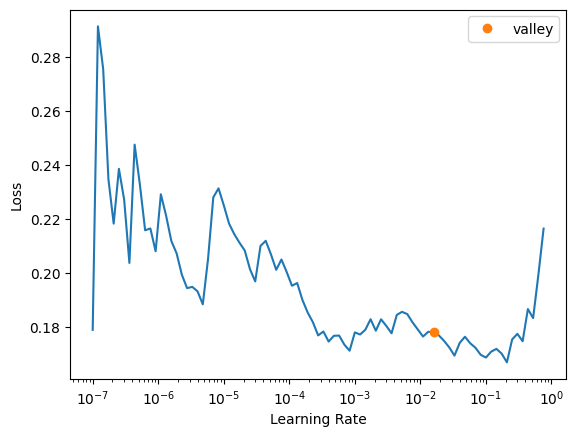

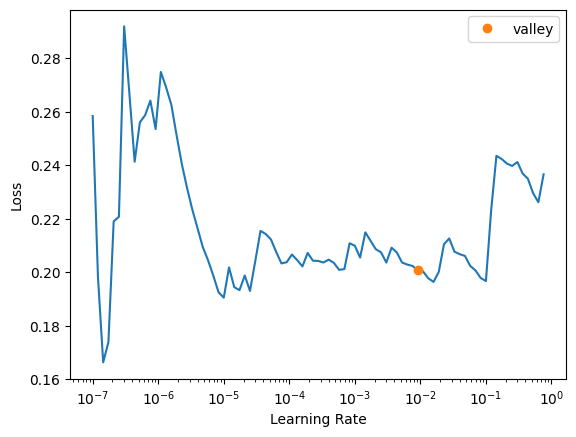

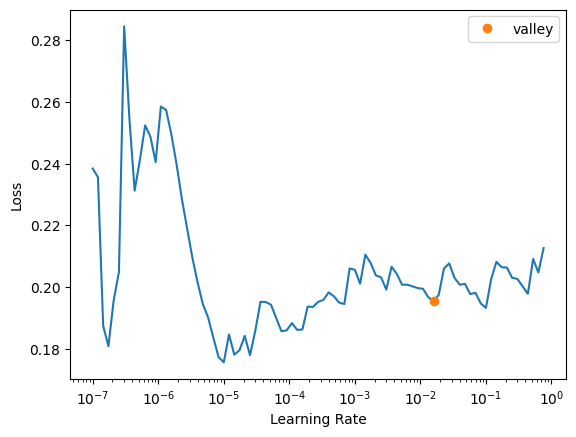

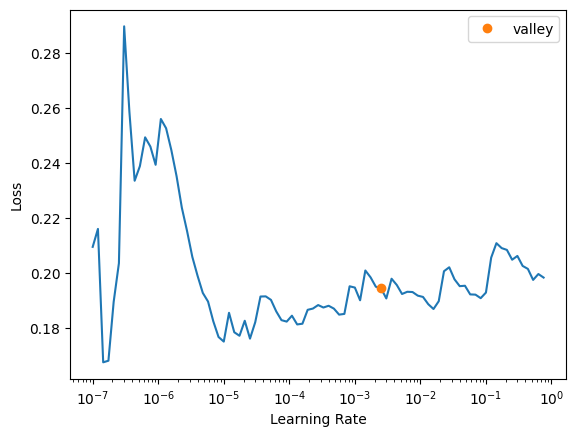

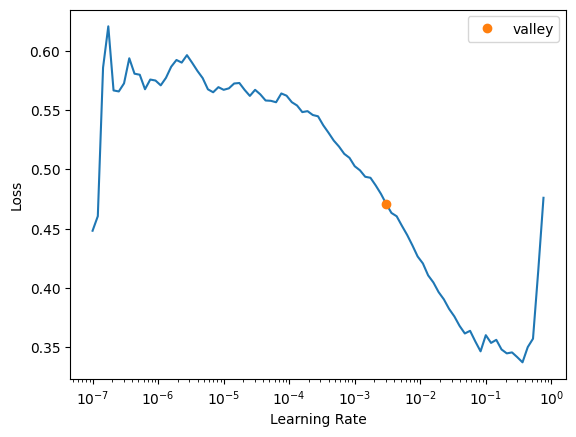

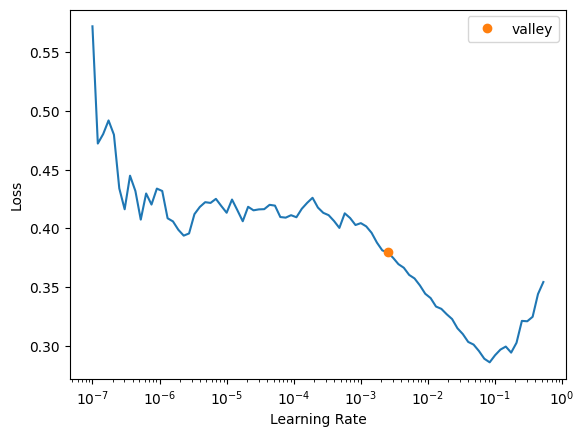

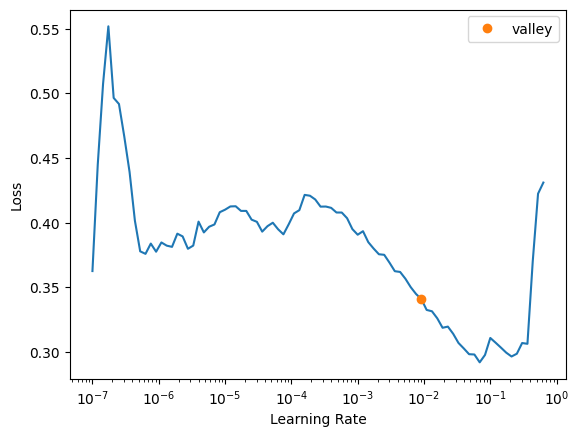

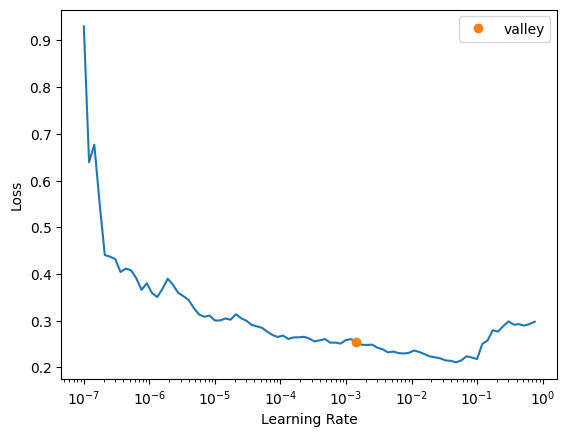

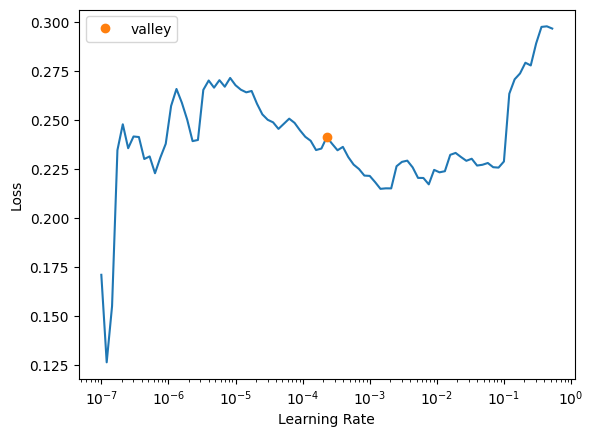

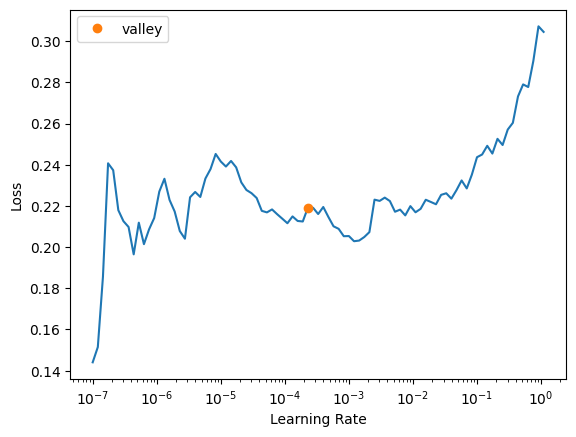

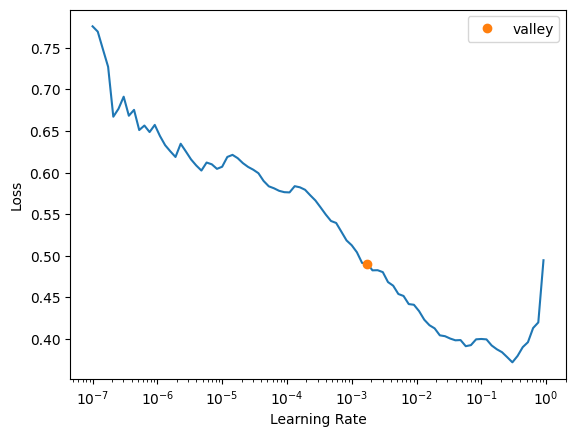

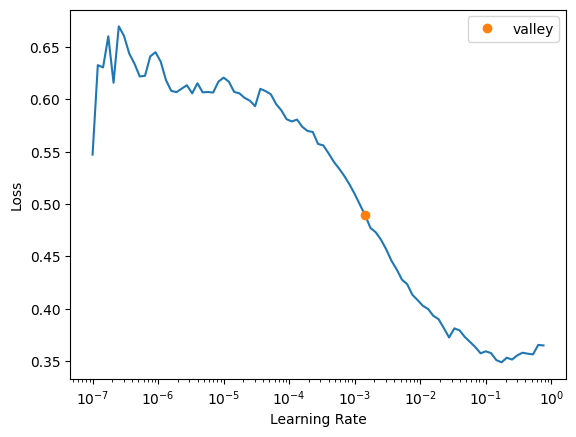

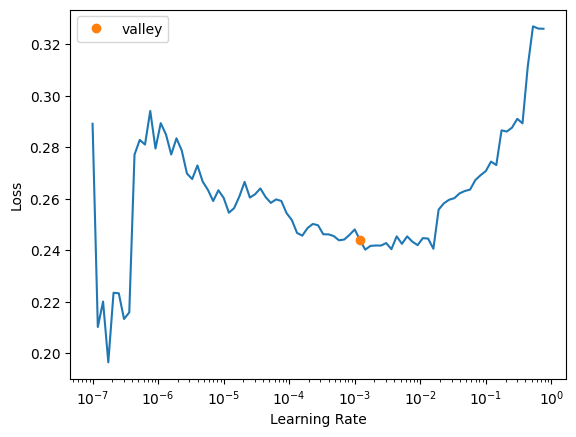

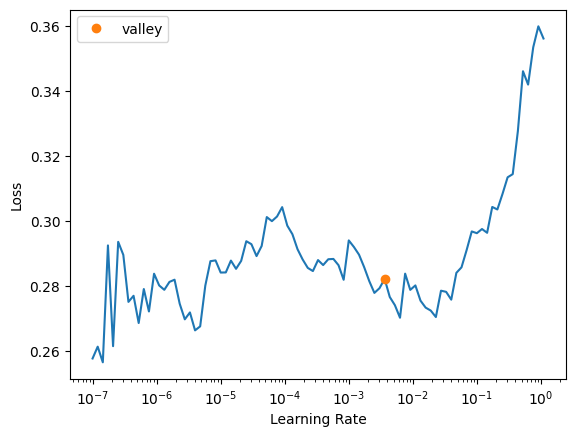

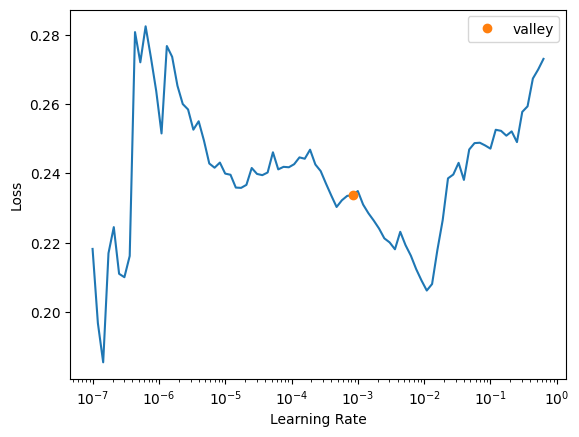

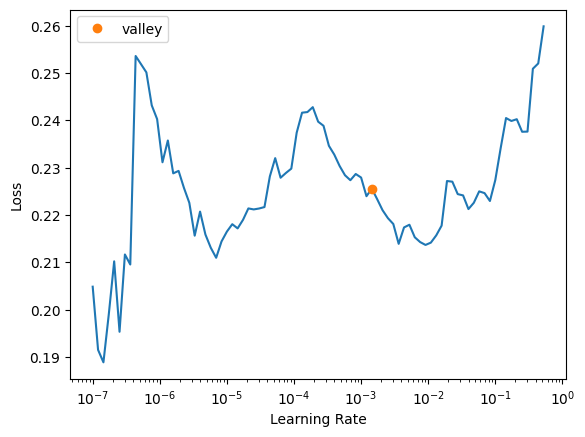

In [73]:
# SHADE-ILS-GD
results['SHADE-ILS-GD'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE-ILS-GD'][layer] = utilsTFG.SHADE_ILS_GD(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]),  max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS-GD'][layer] = end-start


In [74]:
#Validation error
fitness_valid['SHADE-ILS-GD'] = {}
for layer in n_layers:
  fitness_valid['SHADE-ILS-GD'][layer] = []
  for ind in results['SHADE-ILS-GD'][layer][3]:
    fitness_valid['SHADE-ILS-GD'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [75]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-ILS-GD for {layer} layers: {results['SHADE-ILS-GD'][layer][2]}")
  print(f"Validation error of SHADE-ILS-GD for {layer} layers: {fitness_valid['SHADE-ILS-GD'][layer]}")
  dif = np.array(fitness_valid['SHADE-ILS-GD'][layer]) - np.array(results['SHADE-ILS-GD'][layer][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS-GD'][layer])
  best['SHADE-ILS-GD'][layer] = results['SHADE-ILS-GD'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS-GD for 1 layers: [0.6987293362617493, 0.1843482404947281, 0.170287624001503, 0.170287624001503, 0.170287624001503, 0.170287624001503, 0.170287624001503, 0.170287624001503, 0.170287624001503, 0.170287624001503, 0.170287624001503, 0.170287624001503, 0.1515541970729828, 0.1515541970729828, 0.1515541970729828, 0.1489616334438324, 0.1489616334438324, 0.1489616334438324, 0.1489616334438324, 0.1489616334438324, 0.1489616334438324, 0.14183339476585388]
Validation error of SHADE-ILS-GD for 1 layers: [0.51432865858078, 0.2274128496646881, 0.25288596749305725, 0.25288596749305725, 0.25288596749305725, 0.25288596749305725, 0.25288596749305725, 0.25288596749305725, 0.25288596749305725, 0.25288596749305725, 0.25288596749305725, 0.25288596749305725, 0.26281899213790894, 0.26281899213790894, 0.26281899213790894, 0.24344868957996368, 0.24344868957996368, 0.24344868957996368, 0.24344868957996368, 0.24344868957996368, 0.24344868957996368, 0.11570766568183899]
Difference: [-0.1

### Save or load

In [77]:
#Save the mh results
file_path = f'/notebooks/saved_models/mh_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results, f)

In [ ]:
#Load the trained mh results
#file_path = f'/notebooks/saved_models/mh_dict_{dataset}.pkl'
#with open(file_path, 'rb') as f:
#    results = pickle.load(f)

### Comparison between MH

In [78]:
#Saving training loss for better manipulation
training = {}
for mh in algs:
  training[mh] = {}
for layer in n_layers:
  training['SHADE'][layer] = results['SHADE'][layer][6]
  training['SHADE-ILS'][layer] = results['SHADE-ILS'][layer][2]
  training['SHADE-GD'][layer] = results['SHADE-GD'][layer][2]
  training['SHADE-ILS-GD'][layer] = results['SHADE-ILS-GD'][layer][2]

In [79]:
#Calculate accuracy and balanced accuracy
bal_acc = {}
for mh in algs:
  bal_acc[mh] = {}
  for layer in n_layers:
    bal_acc[mh][layer] = []
    ind = 5 if mh == 'SHADE' else 3
    for model in results[mh][layer][ind]:
      utilsTFG.set_params_to_model(model, mh_learners[layer].model)
      mh_learners[layer].model.eval()
      mh_learners[layer].eval()
      preds, targs = mh_learners[layer].get_preds(dl=dls.valid)
      targs = targs.long().squeeze()

      # Calculate balanced_accuracy
      bal_acc[mh][layer].append(utilsTFG.balanced_accuracy_func(preds, targs))

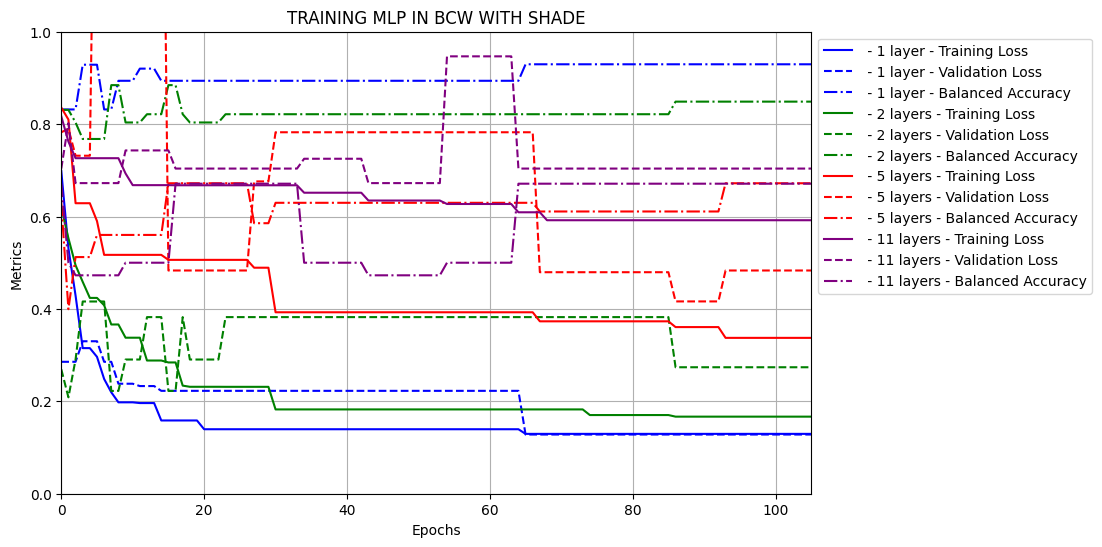

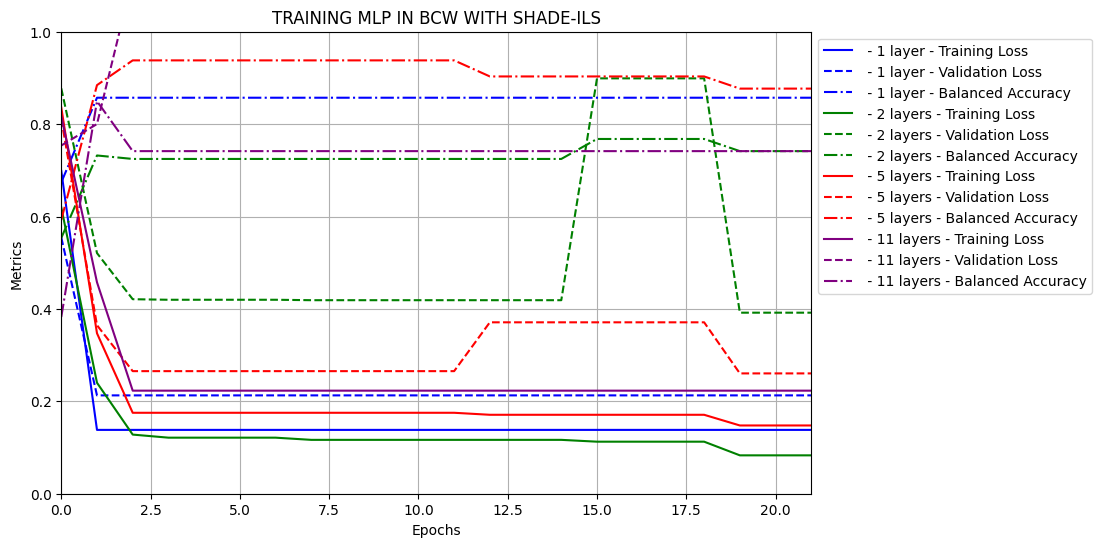

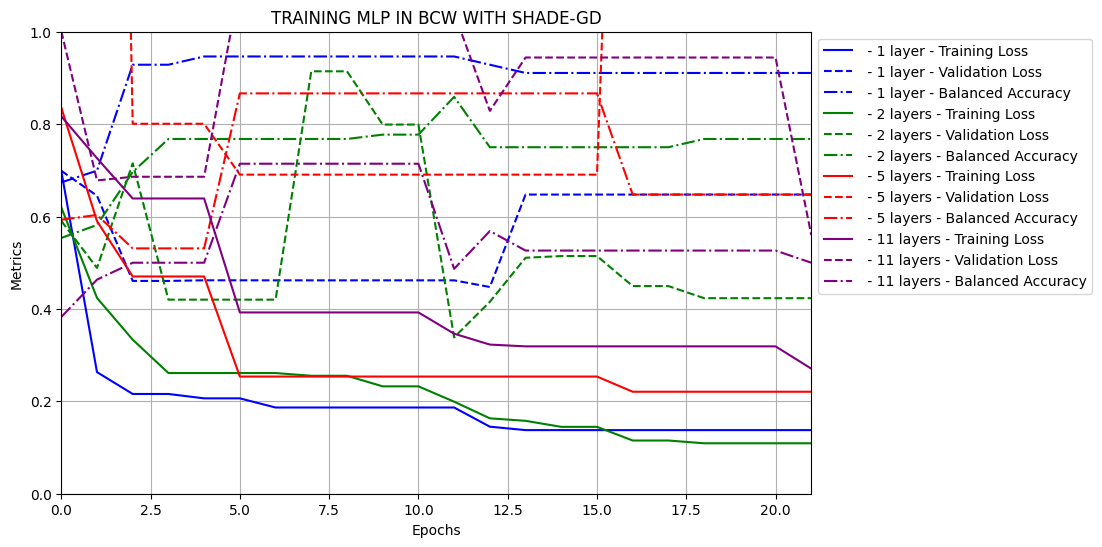

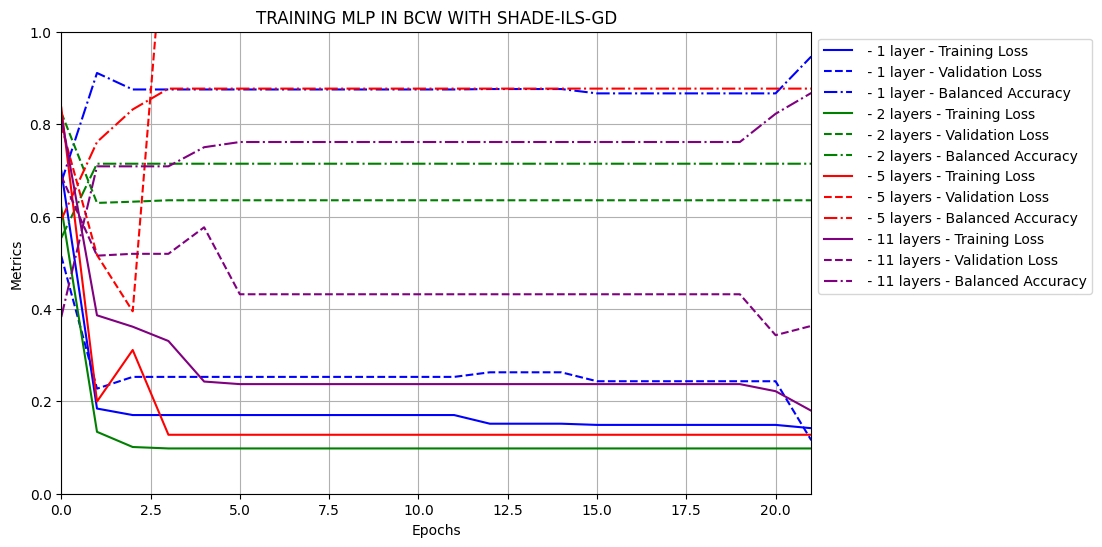

In [80]:
#Comparing the different layers version of the same MH
names= ['1 layer', '2 layers', '5 layers', '11 layers']
for alg in algs:
  utilsTFG.plot_mh_mlp_training(training[alg], fitness_valid[alg], bal_acc[alg],  layers = n_layers, names=names, title=f'TRAINING MLP IN BCW WITH {alg}')

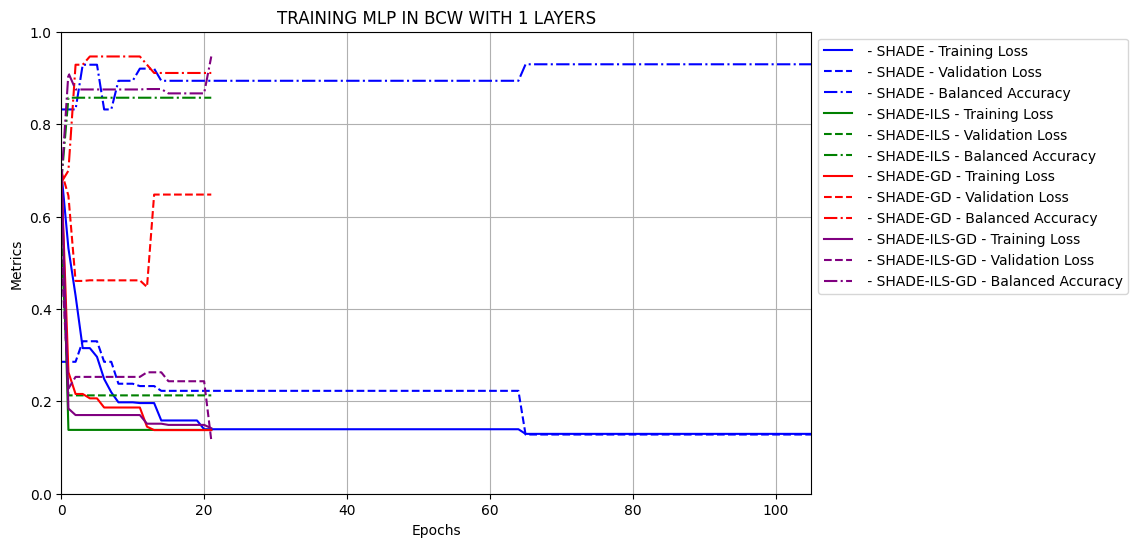

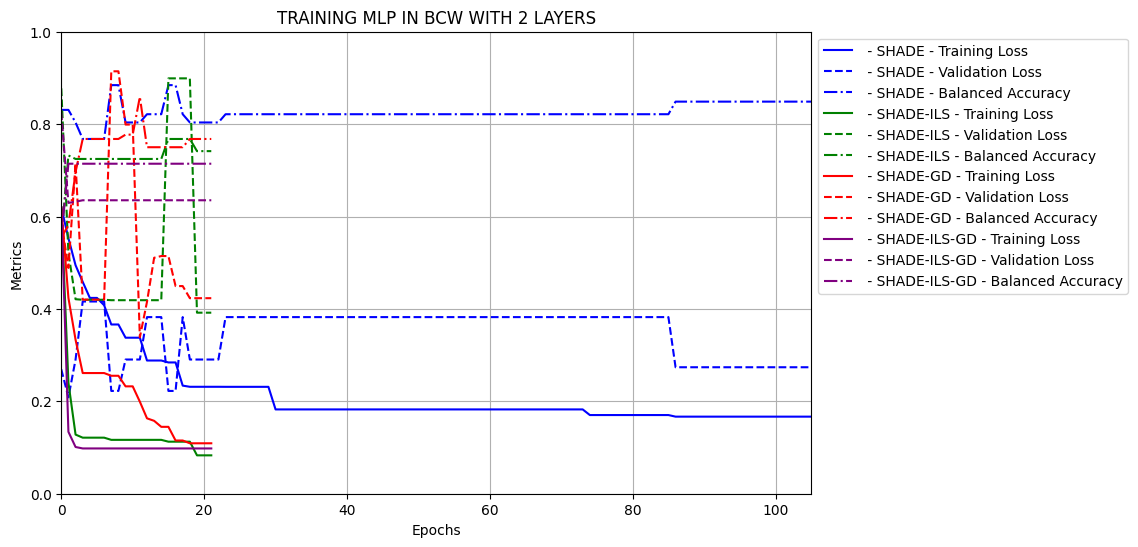

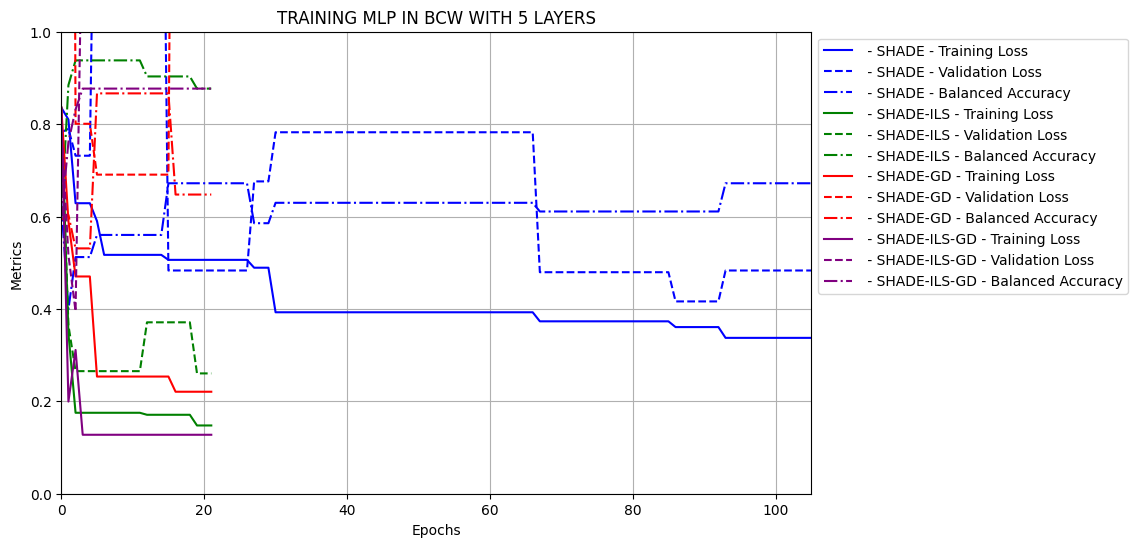

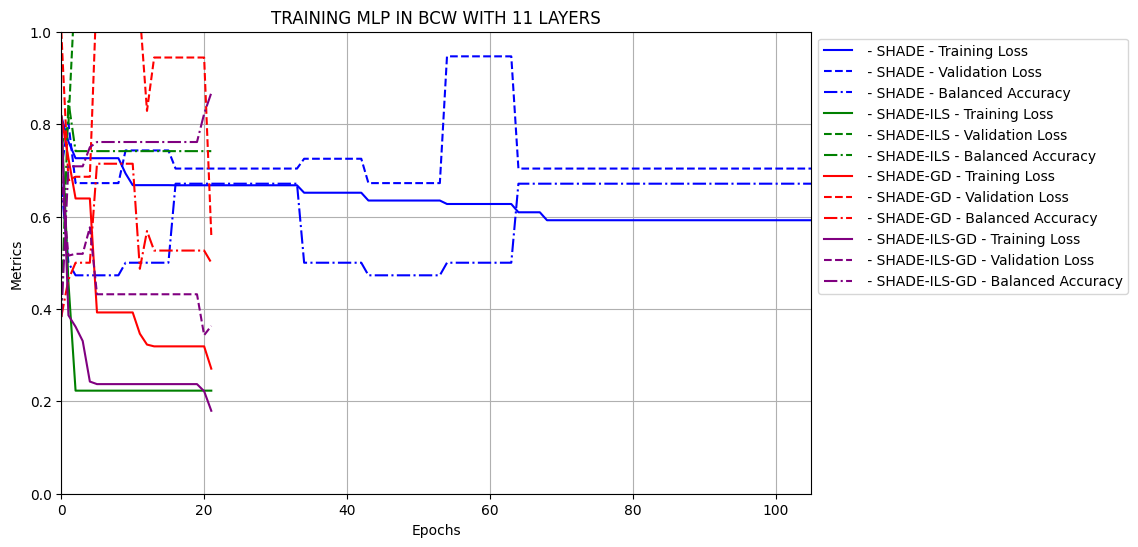

In [81]:
#Comparing the different MH for the same layer number

names= ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
train = {}
acc = {}
valid = {}
for layer in n_layers:
  train[layer] = {}
  acc[layer] = {}
  valid[layer] = {}
  for alg in algs:
    train[layer][alg] = training[alg][layer]
    acc[layer][alg] = bal_acc[alg][layer]
    valid[layer][alg] = fitness_valid[alg][layer]
  utilsTFG.plot_mh_mlp_training(train[layer], valid[layer], acc[layer], layers = names, names=names, title=f'TRAINING MLP IN BCW WITH {layer} LAYERS')

### Generalization

In [82]:
#Run the model in the test set
for mh in algs:
  for layer in n_layers:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    utilsTFG.set_params_to_model(best[mh][layer], mh_learners[layer].model)
    mh_learners[layer].model.eval()
    mh_learners[layer].eval()
    preds, targs = mh_learners[layer].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    #Calculate balanced accuracy

    ac = utilsTFG.balanced_accuracy_func(preds, targs)

    #Calculate F1-Score
    #f1 = utilsTFG.f1_score_func(preds, targs)

    loss = utilsTFG.err_param_w_model(mh_learners[layer].model, test_dl, mode = 'test')

    print(f"Optimizer: {mh}, Layers: {layer}, Loss: {loss}, Balanced accuracy: {ac}")

Optimizer: SHADE, Layers: 1, Loss: 0.21686866879463196, Balanced accuracy: 0.929080541696365


Optimizer: SHADE, Layers: 2, Loss: 0.3652373254299164, Balanced accuracy: 0.8287598004276551


Optimizer: SHADE, Layers: 5, Loss: 0.7813959121704102, Balanced accuracy: 0.6348895224518889


Optimizer: SHADE, Layers: 11, Loss: 0.7220967411994934, Balanced accuracy: 0.4673913043478261


Optimizer: SHADE-ILS, Layers: 1, Loss: 0.25685176253318787, Balanced accuracy: 0.8913043478260869


Optimizer: SHADE-ILS, Layers: 2, Loss: 0.6528031229972839, Balanced accuracy: 0.7309337134711333


Optimizer: SHADE-ILS, Layers: 5, Loss: 1.7307065725326538, Balanced accuracy: 0.9044903777619386


Optimizer: SHADE-ILS, Layers: 11, Loss: 0.6784637570381165, Balanced accuracy: 0.5880256593014968


Optimizer: SHADE-GD, Layers: 1, Loss: 0.3226681351661682, Balanced accuracy: 0.8993228795438346


Optimizer: SHADE-GD, Layers: 2, Loss: 0.41688668727874756, Balanced accuracy: 0.7706699928724163


Optimizer: SHADE-GD, Layers: 5, Loss: 0.29542362689971924, Balanced accuracy: 0.8993228795438346


Optimizer: SHADE-GD, Layers: 11, Loss: 274.7506103515625, Balanced accuracy: 0.5


Optimizer: SHADE-ILS-GD, Layers: 1, Loss: 0.1913386583328247, Balanced accuracy: 0.9239130434782609


Optimizer: SHADE-ILS-GD, Layers: 2, Loss: 0.5117530226707458, Balanced accuracy: 0.6847826086956521


Optimizer: SHADE-ILS-GD, Layers: 5, Loss: 0.23652209341526031, Balanced accuracy: 0.90751960085531


Optimizer: SHADE-ILS-GD, Layers: 11, Loss: 0.32755422592163086, Balanced accuracy: 0.9048467569493941


## Time comparison

In [83]:
#Compare times for each algorithm and layer

#GD
for alg, time_layers in time_mh.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {alg} training with {layer} layers: {time:.04f} seconds')

#MH
for optims, time_layers in time_gd.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {optims} training with {layer} layers: {time:.04f} seconds')



Time consumed by SHADE training with 1 layers: 124.1668 seconds
Time consumed by SHADE training with 2 layers: 138.0652 seconds
Time consumed by SHADE training with 5 layers: 198.4653 seconds
Time consumed by SHADE training with 11 layers: 873.6351 seconds
Time consumed by SHADE-ILS training with 1 layers: 129.9223 seconds
Time consumed by SHADE-ILS training with 2 layers: 141.1876 seconds
Time consumed by SHADE-ILS training with 5 layers: 221.8513 seconds
Time consumed by SHADE-ILS training with 11 layers: 1006.0912 seconds
Time consumed by SHADE-GD training with 1 layers: 131.1064 seconds
Time consumed by SHADE-GD training with 2 layers: 141.7378 seconds
Time consumed by SHADE-GD training with 5 layers: 210.0673 seconds
Time consumed by SHADE-GD training with 11 layers: 900.7455 seconds
Time consumed by SHADE-ILS-GD training with 1 layers: 136.8454 seconds
Time consumed by SHADE-ILS-GD training with 2 layers: 151.8912 seconds
Time consumed by SHADE-ILS-GD training with 5 layers: 227.